# < 3주차 과제 1 : MLP 마음대로 다뤄보기>
- dataset을 임의로 선정해서 직접 분석 해보기(제공한 코드를 활용해서 해보기)
- activation functions 중 relu사용시 함수 직접 정의
- lr, optimizer 등 바꿔보기
- hidden layer/neuron 수를 바꾸기
- 전처리도 추가
- 모든 시도를 올려주세요!
- 제일 높은 acc를 보인 시도를 명시해주세요!


In [1]:
import torch
from torch import nn, optim
from sklearn.datasets import load_breast_cancer
from torch.utils.data import  TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

## 아래 데이터셋 중 원하는 데이터셋 하나를 선택하여, 코드 과제 진행하기!
- 1) load_digits() <br>
- 2) load_wine()

In [2]:

# 데이터셋 종류 :
data = load_breast_cancer() #유방암 데이터를 불러옴

In [3]:
input = data.data # 입력 데이터를 나타냄
output = data.target # 출력 데이터, 유방암 양성/음성 여부를 나타내는 클래스 레이블

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device == "cuda":
  torch.cuda.manual_seed_all(777)

In [5]:
x_train, x_test, y_train, y_test = train_test_split(input, output, test_size = 0.3, random_state = 42, stratify= data.target, shuffle = True)

x_train = torch.FloatTensor(x_train).to(device)
y_train = torch.LongTensor(y_train).to(device)
x_test = torch.FloatTensor(x_test)
y_test = torch.LongTensor(y_test)

# 데이터를 tensor로 바꿔주고 gpu 연산이 가능해지도록 gpu에 옮김
# label 값을 왜 long 에 옮겨놓는가? loss function이 다르기 때문

In [6]:
print(x_train[0])
print(y_train[0])

#input 30개 (속성이 30개)
#y의 class는 2개 (양성과 음성)

tensor([1.1620e+01, 1.8180e+01, 7.6380e+01, 4.0880e+02, 1.1750e-01, 1.4830e-01,
        1.0200e-01, 5.5640e-02, 1.9570e-01, 7.2550e-02, 4.1010e-01, 1.7400e+00,
        3.0270e+00, 2.7850e+01, 1.4590e-02, 3.2060e-02, 4.9610e-02, 1.8410e-02,
        1.8070e-02, 5.2170e-03, 1.3360e+01, 2.5400e+01, 8.8140e+01, 5.2810e+02,
        1.7800e-01, 2.8780e-01, 3.1860e-01, 1.4160e-01, 2.6600e-01, 9.2700e-02])
tensor(1)


파이토치에서는 데이터셋을 좀 더 쉽게 다룰 수 있도록 유용한 도구로서 torch.utils.data.Dataset과 torch.utils.data.DataLoader를 제공합니다. 이를 사용하면 미니 배치 학습, 데이터 셔플(shuffle), 병렬 처리까지 간단히 수행할 수 있습니다. 기본적인 사용 방법은 Dataset을 정의하고, 이를 DataLoader에 전달하는 것
- init : class 에서 객체가 생성되면 바로 실행되는 함수
- len : observation 수를 정의하는 함수
- getitem : iteration 마다 해당하는 데이터를 돌려주는 함수

In [7]:
from torch.utils.data import Dataset
class CustomDataset(Dataset):
  def __init__(self): # 데이터셋의 입력 데이터/ 출력 데이터 초기화
    self.x_data = x_train
    self.y_data = [[y] for y in y_train]
#  데이터셋의 전처리를 해주는 부분

  def __len__(self):
    return len(self.x_data)
#  데이터셋의 길이. 즉, 총 샘플의 수를 적어주는 부분

  def __getitem__(self, idx): # 특정 인덱스에 해당하는
    x = torch.FloatTensor(self.x_data[idx]).to(device)
    y = torch.LongTensor(self.y_data[idx]).to(device)
#  데이터셋에서 특정 1개의 샘플을 가져오는 함수

    return x,y

In [8]:
batch_size = 8

dataset = CustomDataset() # 객체를 생성해서 커스텀데이터셋 만듬
dataloader = DataLoader(dataset, batch_size=batch_size) # 데이터셋, 배치 크기 전달

In [9]:
# input_layer와 hidden_layer의 노드 개수를 어떻게 바꿔줘야할까?
# hidden layer/neuron 수를 바꾸기

model = nn.Sequential(
          nn.Linear(30,398, bias=True),
          nn.Sigmoid(),
          nn.Linear(398,15, bias=True),
          nn.Sigmoid(),
          nn.Linear(15,5, bias=True),
          nn.Softmax()
          ).to(device)

class로 구현 가능
- init : 초기 생성 함수
- foward : 순전파(입력값 => 예측값 의 과정)

In [10]:
class Model(torch.nn.Module):

  def __init__(self):
    super(Model, self).__init__()
    self.layer1 = nn.Sequential(
          nn.Linear(30,398, bias=True), # input_layer = 30, hidden_layer1 = 398
          nn.Sigmoid(),
        nn.BatchNorm1d(398)
    )
  # activation function 이용
  #   nn.ReLU()
  #   nn.tanH()
  #   https://pytorch.org/docs/stable/nn.html 그 외에도 여기서 확인 가능함
  #   파라미터가 필요하지 않다는 것이 특징

  # batch normazliation 1d, 파라미터 값으로 vector의 길이를 전해줌
  # 추후에 이미지를 다루게 된다면, 그때는 batch normalization 2d를 이용하게 됨
  # 그때는 파라미터 값으로 채널, 가로, 세로 길이를 전달해주게 됨

    self.layer2 = nn.Sequential(
          nn.Linear(398,15, bias=True), # hidden_layer1 = 398, hidden_layer2 = 15
        nn.Sigmoid()
    )
    self.layer3 = nn.Sequential(
          nn.Linear(15,10, bias=True), # hidden_layer1 = 15, hidden_layer2 = 10
        nn.Sigmoid()
    )
    self.layer4 = nn.Sequential(
        nn.Linear(10, 5, bias=True), # hidden_layer3 = 10, output_layer = 5
        nn.Softmax()
    )

  def forward(self,x):
    output = self.layer1(x)
    output = self.layer2(output)
    output = self.layer3(output)
    output = self.layer4(output)
    return output

In [11]:
def init_weights(layer):
    if isinstance(layer, nn.Linear):
        torch.nn.init.xavier_uniform(layer.weight)
        layer.bias.data.fill_(0.01)

        #xavier사용
        # Layer의 weight를 어떤 분포를 가지도록 초기화시켜줌+global minimum찾기 위해서

In [12]:
model = Model().to(device)
model.apply(init_weights)

C:\Users\withy\AppData\Local\Temp\ipykernel_8516\2101624760.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(layer.weight)


Model(
  (layer1): Sequential(
    (0): Linear(in_features=30, out_features=398, bias=True)
    (1): Sigmoid()
    (2): BatchNorm1d(398, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=398, out_features=15, bias=True)
    (1): Sigmoid()
  )
  (layer3): Sequential(
    (0): Linear(in_features=15, out_features=10, bias=True)
    (1): Sigmoid()
  )
  (layer4): Sequential(
    (0): Linear(in_features=10, out_features=5, bias=True)
    (1): Softmax(dim=None)
  )
)

In [13]:
print(model)

Model(
  (layer1): Sequential(
    (0): Linear(in_features=30, out_features=398, bias=True)
    (1): Sigmoid()
    (2): BatchNorm1d(398, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=398, out_features=15, bias=True)
    (1): Sigmoid()
  )
  (layer3): Sequential(
    (0): Linear(in_features=15, out_features=10, bias=True)
    (1): Sigmoid()
  )
  (layer4): Sequential(
    (0): Linear(in_features=10, out_features=5, bias=True)
    (1): Softmax(dim=None)
  )
)


In [14]:
loss_fn  = nn.CrossEntropyLoss().to(device)

# 여러가지 optimizer 시도해보기
# lr 바꿔보기


optimizer = optim.Adam(model.parameters(), lr= 0.01)

# https://pytorch.org/docs/stable/optim.html#module-torch.optim 페이지 참조
# optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
# sgd 등등

In [15]:
losses = []
for epoch in range(100):

  optimizer.zero_grad()
  hypothesis = model(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())

C:\Users\withy\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


0 1.6726161241531372
10 1.3783493041992188
20 1.1654633283615112
30 1.0707520246505737
40 1.0233969688415527
50 0.998358428478241
60 1.0109995603561401
70 0.9915383458137512
80 1.0449525117874146
90 0.9944688081741333


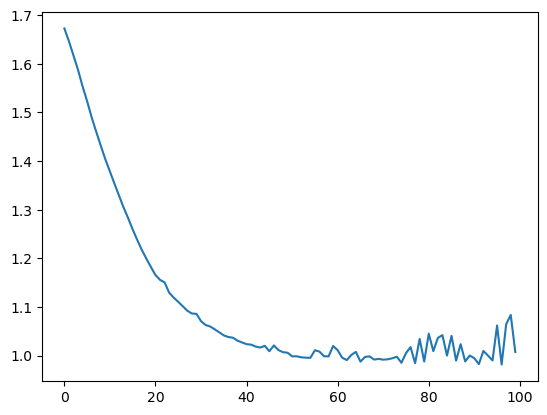

In [16]:
plt.plot(losses)
plt.show()

In [17]:
with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))

In [18]:
print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

model의 output은 :  [0.01058868 0.9798797  0.00325224 0.00299292 0.0032865 ]
argmax를 한 후의 output은 1
accuracy는 0.9181286549707602


### load_digits() 데이터셋 선택

활성화함수 : sigmoid/ReLU/Tanh 사용 \
옵티마이저 : Adam/ Adagrad/RMSprop/SGD 사용\
가장 정확도 높았던 시도1(Sigmoid/Adam), 시도9(Sigmoid/Adagrad)만 Ir 변화시켜봄\
시도 1은 Ir = 0.01, 0.03일 때 정확도 0.9833\
시도 9는 Ir = 0.03일 때 정확도 0.9814 


최고 정확도 : 0.9833

시도1\
활성화함수 : sigmoid \
optimizer : adam 사용 lr= 0.03\
accuracy : 0.9833

In [19]:
from sklearn.datasets import load_digits
data=load_digits()

In [20]:
input = data.data # 입력 데이터를 나타냄
output = data.target # 출력 데이터, 유방암 양성/음성 여부를 나타내는 클래스 레이블
print(input.shape, output.shape)

(1797, 64) (1797,)


In [21]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device == "cuda":
  torch.cuda.manual_seed_all(777)

In [22]:
x_train, x_test, y_train, y_test = train_test_split(input, output, test_size = 0.3, random_state = 42, stratify= data.target, shuffle = True)

x_train = torch.FloatTensor(x_train).to(device)
y_train = torch.LongTensor(y_train).to(device)
x_test = torch.FloatTensor(x_test)
y_test = torch.LongTensor(y_test)
print(x_train.shape, y_train.shape)
print(torch.unique(y_train))
# 데이터를 tensor로 바꿔주고 gpu 연산이 가능해지도록 gpu에 옮김
# label 값을 왜 long 에 옮겨놓는가? loss function이 다르기 때문

torch.Size([1257, 64]) torch.Size([1257])
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


In [23]:
print(x_train[0])
print(y_train[0])

#input 30개 (속성이 30개)
#y의 class는 2개 (양성과 음성)

tensor([ 0.,  0.,  0., 16., 12.,  1.,  0.,  0.,  0.,  0.,  6., 16., 14.,  7.,
         0.,  0.,  0.,  0., 14., 15.,  1., 11.,  0.,  0.,  0.,  0., 16., 15.,
         0., 14.,  1.,  0.,  0.,  1., 16., 10.,  0., 14.,  2.,  0.,  0.,  0.,
        15., 13.,  3., 15.,  3.,  0.,  0.,  0.,  9., 16., 16., 15.,  0.,  0.,
         0.,  0.,  0., 13., 16.,  8.,  0.,  0.])
tensor(0)


In [24]:
from torch.utils.data import Dataset
class CustomDataset(Dataset):
  def __init__(self): # 데이터셋의 입력 데이터/ 출력 데이터 초기화
    self.x_data = x_train
    self.y_data = [[y] for y in y_train]
#  데이터셋의 전처리를 해주는 부분

  def __len__(self):
    return len(self.x_data)
#  데이터셋의 길이. 즉, 총 샘플의 수를 적어주는 부분

  def __getitem__(self, idx): # 특정 인덱스에 해당하는
    x = torch.FloatTensor(self.x_data[idx]).to(device)
    y = torch.LongTensor(self.y_data[idx]).to(device)
#  데이터셋에서 특정 1개의 샘플을 가져오는 함수

    return x,y

In [25]:
batch_size = 8

dataset = CustomDataset() # 객체를 생성해서 커스텀데이터셋 만듬
dataloader = DataLoader(dataset, batch_size=batch_size) # 데이터셋, 배치 크기 전달

In [26]:
# input_layer와 hidden_layer의 노드 개수를 어떻게 바꿔줘야할까?
# hidden layer/neuron 수를 바꾸기

model = nn.Sequential(
          nn.Linear(64,1257, bias=True),
          nn.Sigmoid(),
          nn.Linear(1257,30, bias=True),
          nn.Sigmoid(),
          nn.Linear(30,15, bias=True),
          nn.Sigmoid(),
          nn.Linear(15,10, bias=True),

          nn.Softmax()
          ).to(device)

In [27]:
class Model(torch.nn.Module):

  def __init__(self):
    super(Model, self).__init__()
    self.layer1 = nn.Sequential(
          nn.Linear(64,1257, bias=True), # input_layer = 30, hidden_layer1 = 398
          nn.Sigmoid(),
        nn.BatchNorm1d(1257)
    )
  # activation function 이용
  #   nn.ReLU()
  #   nn.tanH()
  #   https://pytorch.org/docs/stable/nn.html 그 외에도 여기서 확인 가능함
  #   파라미터가 필요하지 않다는 것이 특징

  # batch normazliation 1d, 파라미터 값으로 vector의 길이를 전해줌
  # 추후에 이미지를 다루게 된다면, 그때는 batch normalization 2d를 이용하게 됨
  # 그때는 파라미터 값으로 채널, 가로, 세로 길이를 전달해주게 됨

    self.layer2 = nn.Sequential(
          nn.Linear(1257,30, bias=True), # hidden_layer1 = 398, hidden_layer2 = 30
        nn.Sigmoid()
    )
    self.layer3 = nn.Sequential(
          nn.Linear(30,15, bias=True), # hidden_layer1 = 30, hidden_layer2 = 15

        nn.Sigmoid()
    )

    self.layer4 = nn.Sequential(
          nn.Linear(15, 10, bias=True), # hidden_layer3 = 15, output_layer = 10

        nn.Softmax()
    )

  def forward(self,x):
    output = self.layer1(x)
    output = self.layer2(output)
    output = self.layer3(output)
    output = self.layer4(output)
    return output

In [28]:
def init_weights(layer):
    if isinstance(layer, nn.Linear):
        torch.nn.init.xavier_uniform(layer.weight)
        layer.bias.data.fill_(0.01)

        #xavier사용
        # Layer의 weight를 어떤 분포를 가지도록 초기화시켜줌+global minimum찾기 위해서

In [29]:
model = Model().to(device)
model.apply(init_weights)

C:\Users\withy\AppData\Local\Temp\ipykernel_8516\2101624760.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(layer.weight)


Model(
  (layer1): Sequential(
    (0): Linear(in_features=64, out_features=1257, bias=True)
    (1): Sigmoid()
    (2): BatchNorm1d(1257, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=1257, out_features=30, bias=True)
    (1): Sigmoid()
  )
  (layer3): Sequential(
    (0): Linear(in_features=30, out_features=15, bias=True)
    (1): Sigmoid()
  )
  (layer4): Sequential(
    (0): Linear(in_features=15, out_features=10, bias=True)
    (1): Softmax(dim=None)
  )
)

In [30]:
print(model)

Model(
  (layer1): Sequential(
    (0): Linear(in_features=64, out_features=1257, bias=True)
    (1): Sigmoid()
    (2): BatchNorm1d(1257, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=1257, out_features=30, bias=True)
    (1): Sigmoid()
  )
  (layer3): Sequential(
    (0): Linear(in_features=30, out_features=15, bias=True)
    (1): Sigmoid()
  )
  (layer4): Sequential(
    (0): Linear(in_features=15, out_features=10, bias=True)
    (1): Softmax(dim=None)
  )
)


In [31]:
loss_fn  = nn.CrossEntropyLoss().to(device)

# 여러가지 optimizer 시도해보기
# lr 바꿔보기

optimizer = optim.Adam(model.parameters(), lr= 0.03)

# https://pytorch.org/docs/stable/optim.html#module-torch.optim 페이지 참조
# optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
# sgd 등등

In [32]:
losses = []
for epoch in range(100):

  optimizer.zero_grad()
  hypothesis = model(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())

C:\Users\withy\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


0 2.3041915893554688
10 1.9845832586288452
20 1.683902621269226
30 1.5699156522750854
40 1.4893544912338257
50 1.4695602655410767
60 1.4656072854995728
70 1.464250087738037
80 1.4635578393936157
90 1.4631884098052979


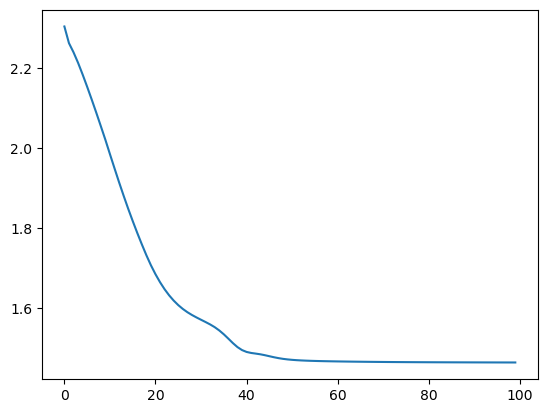

In [33]:
plt.plot(losses)
plt.show()

In [34]:
with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))

In [35]:
print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

model의 output은 :  [8.0366078e-04 9.9807441e-01 7.4196095e-04 6.9685055e-05 2.4225743e-05
 6.4306805e-05 1.9146932e-05 1.2339980e-04 7.6950862e-05 2.2658458e-06]
argmax를 한 후의 output은 1
accuracy는 0.9833333333333333


시도1-1\
활성화함수 : sigmoid \
optimizer : adam 사용 lr= 0.01\
accuracy : 0.9833 -> Ir 줄였지만 정확도는 동일

In [36]:
from sklearn.datasets import load_digits
data=load_digits()

In [37]:
input = data.data # 입력 데이터를 나타냄
output = data.target # 출력 데이터, 유방암 양성/음성 여부를 나타내는 클래스 레이블
print(input.shape, output.shape)

(1797, 64) (1797,)


In [38]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device == "cuda":
  torch.cuda.manual_seed_all(777)

In [39]:
x_train, x_test, y_train, y_test = train_test_split(input, output, test_size = 0.3, random_state = 42, stratify= data.target, shuffle = True)

x_train = torch.FloatTensor(x_train).to(device)
y_train = torch.LongTensor(y_train).to(device)
x_test = torch.FloatTensor(x_test)
y_test = torch.LongTensor(y_test)
print(x_train.shape, y_train.shape)
print(torch.unique(y_train))
# 데이터를 tensor로 바꿔주고 gpu 연산이 가능해지도록 gpu에 옮김
# label 값을 왜 long 에 옮겨놓는가? loss function이 다르기 때문

torch.Size([1257, 64]) torch.Size([1257])
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


In [40]:
print(x_train[0])
print(y_train[0])

#input 30개 (속성이 30개)
#y의 class는 2개 (양성과 음성)

tensor([ 0.,  0.,  0., 16., 12.,  1.,  0.,  0.,  0.,  0.,  6., 16., 14.,  7.,
         0.,  0.,  0.,  0., 14., 15.,  1., 11.,  0.,  0.,  0.,  0., 16., 15.,
         0., 14.,  1.,  0.,  0.,  1., 16., 10.,  0., 14.,  2.,  0.,  0.,  0.,
        15., 13.,  3., 15.,  3.,  0.,  0.,  0.,  9., 16., 16., 15.,  0.,  0.,
         0.,  0.,  0., 13., 16.,  8.,  0.,  0.])
tensor(0)


In [41]:
from torch.utils.data import Dataset
class CustomDataset(Dataset):
  def __init__(self): # 데이터셋의 입력 데이터/ 출력 데이터 초기화
    self.x_data = x_train
    self.y_data = [[y] for y in y_train]
#  데이터셋의 전처리를 해주는 부분

  def __len__(self):
    return len(self.x_data)
#  데이터셋의 길이. 즉, 총 샘플의 수를 적어주는 부분

  def __getitem__(self, idx): # 특정 인덱스에 해당하는
    x = torch.FloatTensor(self.x_data[idx]).to(device)
    y = torch.LongTensor(self.y_data[idx]).to(device)
#  데이터셋에서 특정 1개의 샘플을 가져오는 함수

    return x,y

In [42]:
batch_size = 8

dataset = CustomDataset() # 객체를 생성해서 커스텀데이터셋 만듬
dataloader = DataLoader(dataset, batch_size=batch_size) # 데이터셋, 배치 크기 전달

In [43]:
# input_layer와 hidden_layer의 노드 개수를 어떻게 바꿔줘야할까?
# hidden layer/neuron 수를 바꾸기

model = nn.Sequential(
          nn.Linear(64,1257, bias=True),
          nn.Sigmoid(),
          nn.Linear(1257,30, bias=True),
          nn.Sigmoid(),
          nn.Linear(30,15, bias=True),
          nn.Sigmoid(),
          nn.Linear(15,10, bias=True),

          nn.Softmax()
          ).to(device)

In [44]:
class Model(torch.nn.Module):

  def __init__(self):
    super(Model, self).__init__()
    self.layer1 = nn.Sequential(
          nn.Linear(64,1257, bias=True), # input_layer = 30, hidden_layer1 = 398
          nn.Sigmoid(),
        nn.BatchNorm1d(1257)
    )
  # activation function 이용
  #   nn.ReLU()
  #   nn.tanH()
  #   https://pytorch.org/docs/stable/nn.html 그 외에도 여기서 확인 가능함
  #   파라미터가 필요하지 않다는 것이 특징

  # batch normazliation 1d, 파라미터 값으로 vector의 길이를 전해줌
  # 추후에 이미지를 다루게 된다면, 그때는 batch normalization 2d를 이용하게 됨
  # 그때는 파라미터 값으로 채널, 가로, 세로 길이를 전달해주게 됨

    self.layer2 = nn.Sequential(
          nn.Linear(1257,30, bias=True), # hidden_layer1 = 398, hidden_layer2 = 30
        nn.Sigmoid()
    )
    self.layer3 = nn.Sequential(
          nn.Linear(30,15, bias=True), # hidden_layer1 = 30, hidden_layer2 = 15

        nn.Sigmoid()
    )

    self.layer4 = nn.Sequential(
          nn.Linear(15, 10, bias=True), # hidden_layer3 = 15, output_layer = 10

        nn.Softmax()
    )

  def forward(self,x):
    output = self.layer1(x)
    output = self.layer2(output)
    output = self.layer3(output)
    output = self.layer4(output)
    return output

In [45]:
def init_weights(layer):
    if isinstance(layer, nn.Linear):
        torch.nn.init.xavier_uniform(layer.weight)
        layer.bias.data.fill_(0.01)

        #xavier사용
        # Layer의 weight를 어떤 분포를 가지도록 초기화시켜줌+global minimum찾기 위해서

In [46]:
model = Model().to(device)
model.apply(init_weights)

C:\Users\withy\AppData\Local\Temp\ipykernel_8516\2101624760.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(layer.weight)


Model(
  (layer1): Sequential(
    (0): Linear(in_features=64, out_features=1257, bias=True)
    (1): Sigmoid()
    (2): BatchNorm1d(1257, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=1257, out_features=30, bias=True)
    (1): Sigmoid()
  )
  (layer3): Sequential(
    (0): Linear(in_features=30, out_features=15, bias=True)
    (1): Sigmoid()
  )
  (layer4): Sequential(
    (0): Linear(in_features=15, out_features=10, bias=True)
    (1): Softmax(dim=None)
  )
)

In [47]:
print(model)

Model(
  (layer1): Sequential(
    (0): Linear(in_features=64, out_features=1257, bias=True)
    (1): Sigmoid()
    (2): BatchNorm1d(1257, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=1257, out_features=30, bias=True)
    (1): Sigmoid()
  )
  (layer3): Sequential(
    (0): Linear(in_features=30, out_features=15, bias=True)
    (1): Sigmoid()
  )
  (layer4): Sequential(
    (0): Linear(in_features=15, out_features=10, bias=True)
    (1): Softmax(dim=None)
  )
)


In [48]:
loss_fn  = nn.CrossEntropyLoss().to(device)

# 여러가지 optimizer 시도해보기
# lr 바꿔보기

optimizer = optim.Adam(model.parameters(), lr= 0.01)

# https://pytorch.org/docs/stable/optim.html#module-torch.optim 페이지 참조
# optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
# sgd 등등

In [49]:
losses = []
for epoch in range(100):

  optimizer.zero_grad()
  hypothesis = model(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())

0 2.3041915893554688


C:\Users\withy\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


10 2.1673614978790283
20 2.0322039127349854
30 1.8888057470321655
40 1.7664422988891602
50 1.6712431907653809
60 1.599353313446045
70 1.5367558002471924
80 1.5053565502166748
90 1.4897820949554443


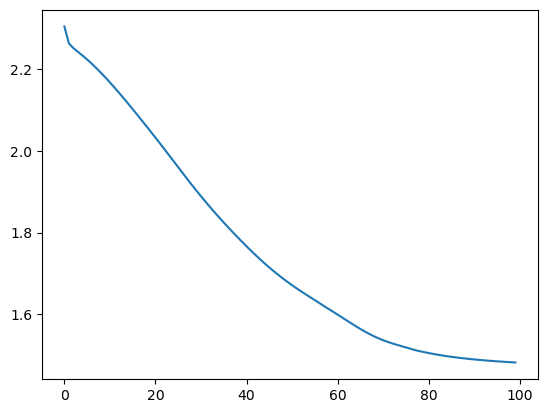

In [50]:
plt.plot(losses)
plt.show()

In [51]:
with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))

In [52]:
print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

model의 output은 :  [4.5020129e-03 9.8336005e-01 4.6892571e-03 1.1774487e-03 8.1090420e-04
 1.6380138e-04 8.2885311e-04 1.7962443e-03 2.6457943e-03 2.5671810e-05]
argmax를 한 후의 output은 1
accuracy는 0.9833333333333333


시도1-2\
활성화함수 : sigmoid \
optimizer : adam 사용 lr= 0.05\
accuracy : 0.9685 -> 감소

In [53]:
from sklearn.datasets import load_digits
data=load_digits()

In [54]:
input = data.data # 입력 데이터를 나타냄
output = data.target # 출력 데이터, 유방암 양성/음성 여부를 나타내는 클래스 레이블
print(input.shape, output.shape)

(1797, 64) (1797,)


In [55]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device == "cuda":
  torch.cuda.manual_seed_all(777)

In [56]:
x_train, x_test, y_train, y_test = train_test_split(input, output, test_size = 0.3, random_state = 42, stratify= data.target, shuffle = True)

x_train = torch.FloatTensor(x_train).to(device)
y_train = torch.LongTensor(y_train).to(device)
x_test = torch.FloatTensor(x_test)
y_test = torch.LongTensor(y_test)
print(x_train.shape, y_train.shape)
print(torch.unique(y_train))
# 데이터를 tensor로 바꿔주고 gpu 연산이 가능해지도록 gpu에 옮김
# label 값을 왜 long 에 옮겨놓는가? loss function이 다르기 때문

torch.Size([1257, 64]) torch.Size([1257])
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


In [57]:
print(x_train[0])
print(y_train[0])

#input 30개 (속성이 30개)
#y의 class는 2개 (양성과 음성)

tensor([ 0.,  0.,  0., 16., 12.,  1.,  0.,  0.,  0.,  0.,  6., 16., 14.,  7.,
         0.,  0.,  0.,  0., 14., 15.,  1., 11.,  0.,  0.,  0.,  0., 16., 15.,
         0., 14.,  1.,  0.,  0.,  1., 16., 10.,  0., 14.,  2.,  0.,  0.,  0.,
        15., 13.,  3., 15.,  3.,  0.,  0.,  0.,  9., 16., 16., 15.,  0.,  0.,
         0.,  0.,  0., 13., 16.,  8.,  0.,  0.])
tensor(0)


In [58]:
from torch.utils.data import Dataset
class CustomDataset(Dataset):
  def __init__(self): # 데이터셋의 입력 데이터/ 출력 데이터 초기화
    self.x_data = x_train
    self.y_data = [[y] for y in y_train]
#  데이터셋의 전처리를 해주는 부분

  def __len__(self):
    return len(self.x_data)
#  데이터셋의 길이. 즉, 총 샘플의 수를 적어주는 부분

  def __getitem__(self, idx): # 특정 인덱스에 해당하는
    x = torch.FloatTensor(self.x_data[idx]).to(device)
    y = torch.LongTensor(self.y_data[idx]).to(device)
#  데이터셋에서 특정 1개의 샘플을 가져오는 함수

    return x,y

In [59]:
batch_size = 8

dataset = CustomDataset() # 객체를 생성해서 커스텀데이터셋 만듬
dataloader = DataLoader(dataset, batch_size=batch_size) # 데이터셋, 배치 크기 전달

In [60]:
# input_layer와 hidden_layer의 노드 개수를 어떻게 바꿔줘야할까?
# hidden layer/neuron 수를 바꾸기

model = nn.Sequential(
          nn.Linear(64,1257, bias=True),
          nn.Sigmoid(),
          nn.Linear(1257,30, bias=True),
          nn.Sigmoid(),
          nn.Linear(30,15, bias=True),
          nn.Sigmoid(),
          nn.Linear(15,10, bias=True),

          nn.Softmax()
          ).to(device)

In [61]:
class Model(torch.nn.Module):

  def __init__(self):
    super(Model, self).__init__()
    self.layer1 = nn.Sequential(
          nn.Linear(64,1257, bias=True), # input_layer = 30, hidden_layer1 = 398
          nn.Sigmoid(),
        nn.BatchNorm1d(1257)
    )
  # activation function 이용
  #   nn.ReLU()
  #   nn.tanH()
  #   https://pytorch.org/docs/stable/nn.html 그 외에도 여기서 확인 가능함
  #   파라미터가 필요하지 않다는 것이 특징

  # batch normazliation 1d, 파라미터 값으로 vector의 길이를 전해줌
  # 추후에 이미지를 다루게 된다면, 그때는 batch normalization 2d를 이용하게 됨
  # 그때는 파라미터 값으로 채널, 가로, 세로 길이를 전달해주게 됨

    self.layer2 = nn.Sequential(
          nn.Linear(1257,30, bias=True), # hidden_layer1 = 398, hidden_layer2 = 30
        nn.Sigmoid()
    )
    self.layer3 = nn.Sequential(
          nn.Linear(30,15, bias=True), # hidden_layer1 = 30, hidden_layer2 = 15

        nn.Sigmoid()
    )

    self.layer4 = nn.Sequential(
          nn.Linear(15, 10, bias=True), # hidden_layer3 = 15, output_layer = 10

        nn.Softmax()
    )

  def forward(self,x):
    output = self.layer1(x)
    output = self.layer2(output)
    output = self.layer3(output)
    output = self.layer4(output)
    return output

In [62]:
def init_weights(layer):
    if isinstance(layer, nn.Linear):
        torch.nn.init.xavier_uniform(layer.weight)
        layer.bias.data.fill_(0.01)

        #xavier사용
        # Layer의 weight를 어떤 분포를 가지도록 초기화시켜줌+global minimum찾기 위해서

In [63]:
model = Model().to(device)
model.apply(init_weights)

C:\Users\withy\AppData\Local\Temp\ipykernel_8516\2101624760.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(layer.weight)


Model(
  (layer1): Sequential(
    (0): Linear(in_features=64, out_features=1257, bias=True)
    (1): Sigmoid()
    (2): BatchNorm1d(1257, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=1257, out_features=30, bias=True)
    (1): Sigmoid()
  )
  (layer3): Sequential(
    (0): Linear(in_features=30, out_features=15, bias=True)
    (1): Sigmoid()
  )
  (layer4): Sequential(
    (0): Linear(in_features=15, out_features=10, bias=True)
    (1): Softmax(dim=None)
  )
)

In [64]:
print(model)

Model(
  (layer1): Sequential(
    (0): Linear(in_features=64, out_features=1257, bias=True)
    (1): Sigmoid()
    (2): BatchNorm1d(1257, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=1257, out_features=30, bias=True)
    (1): Sigmoid()
  )
  (layer3): Sequential(
    (0): Linear(in_features=30, out_features=15, bias=True)
    (1): Sigmoid()
  )
  (layer4): Sequential(
    (0): Linear(in_features=15, out_features=10, bias=True)
    (1): Softmax(dim=None)
  )
)


In [65]:
loss_fn  = nn.CrossEntropyLoss().to(device)

# 여러가지 optimizer 시도해보기
# lr 바꿔보기

optimizer = optim.Adam(model.parameters(), lr= 0.05)

# https://pytorch.org/docs/stable/optim.html#module-torch.optim 페이지 참조
# optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
# sgd 등등

In [66]:
losses = []
for epoch in range(100):

  optimizer.zero_grad()
  hypothesis = model(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())

0 2.3041915893554688


C:\Users\withy\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


10 1.867556095123291
20 1.58851158618927
30 1.5563104152679443
40 1.4934300184249878
50 1.4710553884506226
60 1.466712236404419
70 1.4663283824920654
80 1.4670255184173584
90 1.4656919240951538


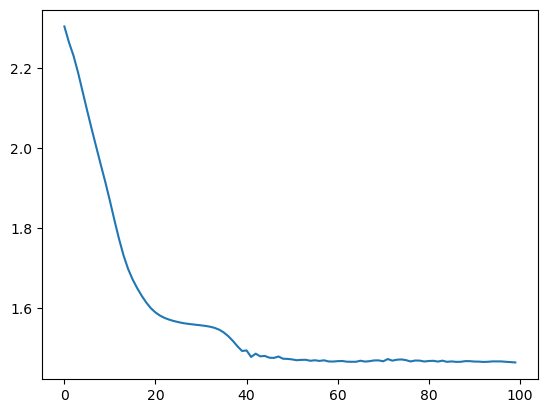

In [67]:
plt.plot(losses)
plt.show()

In [68]:
with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))

In [69]:
print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

model의 output은 :  [1.5456062e-05 9.9954492e-01 3.5182835e-04 6.6821408e-06 1.8054095e-06
 1.3956799e-05 1.3327536e-06 7.4764380e-06 5.6550110e-05 3.9176644e-09]
argmax를 한 후의 output은 1
accuracy는 0.9685185185185186


시도1-3\
활성화함수 : sigmoid \
optimizer : adam 사용 lr= 0.02\
accuracy : 0.9814 ->감소

In [70]:
from sklearn.datasets import load_digits
data=load_digits()

In [71]:
input = data.data # 입력 데이터를 나타냄
output = data.target # 출력 데이터, 유방암 양성/음성 여부를 나타내는 클래스 레이블
print(input.shape, output.shape)

(1797, 64) (1797,)


In [72]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device == "cuda":
  torch.cuda.manual_seed_all(777)

In [73]:
x_train, x_test, y_train, y_test = train_test_split(input, output, test_size = 0.3, random_state = 42, stratify= data.target, shuffle = True)

x_train = torch.FloatTensor(x_train).to(device)
y_train = torch.LongTensor(y_train).to(device)
x_test = torch.FloatTensor(x_test)
y_test = torch.LongTensor(y_test)
print(x_train.shape, y_train.shape)
print(torch.unique(y_train))
# 데이터를 tensor로 바꿔주고 gpu 연산이 가능해지도록 gpu에 옮김
# label 값을 왜 long 에 옮겨놓는가? loss function이 다르기 때문

torch.Size([1257, 64]) torch.Size([1257])
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


In [74]:
print(x_train[0])
print(y_train[0])

#input 30개 (속성이 30개)
#y의 class는 2개 (양성과 음성)

tensor([ 0.,  0.,  0., 16., 12.,  1.,  0.,  0.,  0.,  0.,  6., 16., 14.,  7.,
         0.,  0.,  0.,  0., 14., 15.,  1., 11.,  0.,  0.,  0.,  0., 16., 15.,
         0., 14.,  1.,  0.,  0.,  1., 16., 10.,  0., 14.,  2.,  0.,  0.,  0.,
        15., 13.,  3., 15.,  3.,  0.,  0.,  0.,  9., 16., 16., 15.,  0.,  0.,
         0.,  0.,  0., 13., 16.,  8.,  0.,  0.])
tensor(0)


In [75]:
from torch.utils.data import Dataset
class CustomDataset(Dataset):
  def __init__(self): # 데이터셋의 입력 데이터/ 출력 데이터 초기화
    self.x_data = x_train
    self.y_data = [[y] for y in y_train]
#  데이터셋의 전처리를 해주는 부분

  def __len__(self):
    return len(self.x_data)
#  데이터셋의 길이. 즉, 총 샘플의 수를 적어주는 부분

  def __getitem__(self, idx): # 특정 인덱스에 해당하는
    x = torch.FloatTensor(self.x_data[idx]).to(device)
    y = torch.LongTensor(self.y_data[idx]).to(device)
#  데이터셋에서 특정 1개의 샘플을 가져오는 함수

    return x,y

In [76]:
batch_size = 8

dataset = CustomDataset() # 객체를 생성해서 커스텀데이터셋 만듬
dataloader = DataLoader(dataset, batch_size=batch_size) # 데이터셋, 배치 크기 전달

In [77]:
# input_layer와 hidden_layer의 노드 개수를 어떻게 바꿔줘야할까?
# hidden layer/neuron 수를 바꾸기

model = nn.Sequential(
          nn.Linear(64,1257, bias=True),
          nn.Sigmoid(),
          nn.Linear(1257,30, bias=True),
          nn.Sigmoid(),
          nn.Linear(30,15, bias=True),
          nn.Sigmoid(),
          nn.Linear(15,10, bias=True),

          nn.Softmax()
          ).to(device)

In [78]:
class Model(torch.nn.Module):

  def __init__(self):
    super(Model, self).__init__()
    self.layer1 = nn.Sequential(
          nn.Linear(64,1257, bias=True), # input_layer = 30, hidden_layer1 = 398
          nn.Sigmoid(),
        nn.BatchNorm1d(1257)
    )
  # activation function 이용
  #   nn.ReLU()
  #   nn.tanH()
  #   https://pytorch.org/docs/stable/nn.html 그 외에도 여기서 확인 가능함
  #   파라미터가 필요하지 않다는 것이 특징

  # batch normazliation 1d, 파라미터 값으로 vector의 길이를 전해줌
  # 추후에 이미지를 다루게 된다면, 그때는 batch normalization 2d를 이용하게 됨
  # 그때는 파라미터 값으로 채널, 가로, 세로 길이를 전달해주게 됨

    self.layer2 = nn.Sequential(
          nn.Linear(1257,30, bias=True), # hidden_layer1 = 398, hidden_layer2 = 30
        nn.Sigmoid()
    )
    self.layer3 = nn.Sequential(
          nn.Linear(30,15, bias=True), # hidden_layer1 = 30, hidden_layer2 = 15

        nn.Sigmoid()
    )

    self.layer4 = nn.Sequential(
          nn.Linear(15, 10, bias=True), # hidden_layer3 = 15, output_layer = 10

        nn.Softmax()
    )

  def forward(self,x):
    output = self.layer1(x)
    output = self.layer2(output)
    output = self.layer3(output)
    output = self.layer4(output)
    return output

In [79]:
def init_weights(layer):
    if isinstance(layer, nn.Linear):
        torch.nn.init.xavier_uniform(layer.weight)
        layer.bias.data.fill_(0.01)

        #xavier사용
        # Layer의 weight를 어떤 분포를 가지도록 초기화시켜줌+global minimum찾기 위해서

In [80]:
model = Model().to(device)
model.apply(init_weights)

C:\Users\withy\AppData\Local\Temp\ipykernel_8516\2101624760.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(layer.weight)


Model(
  (layer1): Sequential(
    (0): Linear(in_features=64, out_features=1257, bias=True)
    (1): Sigmoid()
    (2): BatchNorm1d(1257, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=1257, out_features=30, bias=True)
    (1): Sigmoid()
  )
  (layer3): Sequential(
    (0): Linear(in_features=30, out_features=15, bias=True)
    (1): Sigmoid()
  )
  (layer4): Sequential(
    (0): Linear(in_features=15, out_features=10, bias=True)
    (1): Softmax(dim=None)
  )
)

In [81]:
print(model)

Model(
  (layer1): Sequential(
    (0): Linear(in_features=64, out_features=1257, bias=True)
    (1): Sigmoid()
    (2): BatchNorm1d(1257, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=1257, out_features=30, bias=True)
    (1): Sigmoid()
  )
  (layer3): Sequential(
    (0): Linear(in_features=30, out_features=15, bias=True)
    (1): Sigmoid()
  )
  (layer4): Sequential(
    (0): Linear(in_features=15, out_features=10, bias=True)
    (1): Softmax(dim=None)
  )
)


In [82]:
loss_fn  = nn.CrossEntropyLoss().to(device)

# 여러가지 optimizer 시도해보기
# lr 바꿔보기

optimizer = optim.Adam(model.parameters(), lr= 0.02)

# https://pytorch.org/docs/stable/optim.html#module-torch.optim 페이지 참조
# optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
# sgd 등등

In [83]:
losses = []
for epoch in range(100):

  optimizer.zero_grad()
  hypothesis = model(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())

0 2.3041915893554688


C:\Users\withy\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


10 2.071523666381836
20 1.8292443752288818
30 1.6505166292190552
40 1.5686091184616089
50 1.495755672454834
60 1.4763022661209106
70 1.4697680473327637
80 1.4674079418182373
90 1.466125726699829


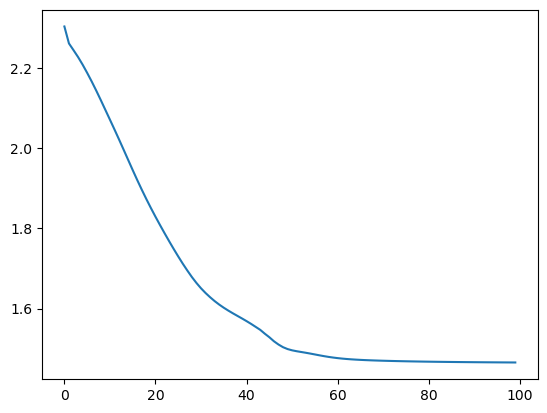

In [84]:
plt.plot(losses)
plt.show()

In [85]:
with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))

In [86]:
print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

model의 output은 :  [6.3983654e-04 9.9625278e-01 1.1827556e-03 1.7054076e-04 1.8748664e-04
 2.0752325e-04 8.1629085e-05 5.2934274e-04 7.4616872e-04 2.0728135e-06]
argmax를 한 후의 output은 1
accuracy는 0.9814814814814815


시도2\
활성화함수 : ReLu \
optimizer : adam 사용 lr= 0.03 \
accuracy : 0.9666

In [87]:
from sklearn.datasets import load_digits
data=load_digits()

In [88]:
input = data.data 
output = data.target 

In [89]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device == "cuda":
  torch.cuda.manual_seed_all(777)

In [90]:
x_train, x_test, y_train, y_test = train_test_split(input, output, test_size = 0.3, random_state = 42, stratify= data.target, shuffle = True)

x_train = torch.FloatTensor(x_train).to(device)
y_train = torch.LongTensor(y_train).to(device)
x_test = torch.FloatTensor(x_test)
y_test = torch.LongTensor(y_test)

In [91]:
from torch.utils.data import Dataset
class CustomDataset(Dataset):
  def __init__(self): # 데이터셋의 입력 데이터/ 출력 데이터 초기화
    self.x_data = x_train
    self.y_data = [[y] for y in y_train]
#  데이터셋의 전처리를 해주는 부분

  def __len__(self):
    return len(self.x_data)
#  데이터셋의 길이. 즉, 총 샘플의 수를 적어주는 부분

  def __getitem__(self, idx): # 특정 인덱스에 해당하는
    x = torch.FloatTensor(self.x_data[idx]).to(device)
    y = torch.LongTensor(self.y_data[idx]).to(device)
#  데이터셋에서 특정 1개의 샘플을 가져오는 함수

    return x,y

In [92]:
batch_size = 8

dataset = CustomDataset() # 객체를 생성해서 커스텀데이터셋 만듬
dataloader = DataLoader(dataset, batch_size=batch_size) # 데이터셋, 배치 크기 전달

In [93]:
# input_layer와 hidden_layer의 노드 개수를 어떻게 바꿔줘야할까?
# hidden layer/neuron 수를 바꾸기

model = nn.Sequential(
          nn.Linear(64,1257, bias=True),
          nn.ReLU(),
          nn.Linear(1257,30, bias=True),
          nn.ReLU(),
          nn.Linear(30,15, bias=True),
          nn.ReLU(),
          nn.Linear(15,10, bias=True),

          nn.Softmax()
          ).to(device)

In [94]:
class Model(torch.nn.Module):

  def __init__(self):
    super(Model, self).__init__()
    self.layer1 = nn.Sequential(
          nn.Linear(64,1257, bias=True), # input_layer = 30, hidden_layer1 = 398
          nn.ReLU(),
        nn.BatchNorm1d(1257)
    )
  # activation function 이용
  #   nn.ReLU()
  #   nn.tanH()
  #   https://pytorch.org/docs/stable/nn.html 그 외에도 여기서 확인 가능함
  #   파라미터가 필요하지 않다는 것이 특징

  # batch normazliation 1d, 파라미터 값으로 vector의 길이를 전해줌
  # 추후에 이미지를 다루게 된다면, 그때는 batch normalization 2d를 이용하게 됨
  # 그때는 파라미터 값으로 채널, 가로, 세로 길이를 전달해주게 됨

    self.layer2 = nn.Sequential(
          nn.Linear(1257,30, bias=True), # hidden_layer1 = 398, hidden_layer2 = 30
        nn.ReLU()
    )
    self.layer3 = nn.Sequential(
          nn.Linear(30,15, bias=True), # hidden_layer1 = 30, hidden_layer2 = 15

        nn.ReLU()
    )

    self.layer4 = nn.Sequential(
          nn.Linear(15, 10, bias=True), # hidden_layer3 = 15, output_layer = 10

        nn.Softmax()
    )

  def forward(self,x):
    output = self.layer1(x)
    output = self.layer2(output)
    output = self.layer3(output)
    output = self.layer4(output)
    return output

In [95]:
def init_weights(layer):
    if isinstance(layer, nn.Linear):
        torch.nn.init.xavier_uniform(layer.weight)
        layer.bias.data.fill_(0.01)

        #xavier사용
        # Layer의 weight를 어떤 분포를 가지도록 초기화시켜줌+global minimum찾기 위해서

In [96]:
model = Model().to(device)
model.apply(init_weights)

C:\Users\withy\AppData\Local\Temp\ipykernel_8516\2101624760.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(layer.weight)


Model(
  (layer1): Sequential(
    (0): Linear(in_features=64, out_features=1257, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(1257, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=1257, out_features=30, bias=True)
    (1): ReLU()
  )
  (layer3): Sequential(
    (0): Linear(in_features=30, out_features=15, bias=True)
    (1): ReLU()
  )
  (layer4): Sequential(
    (0): Linear(in_features=15, out_features=10, bias=True)
    (1): Softmax(dim=None)
  )
)

In [97]:
print(model)

Model(
  (layer1): Sequential(
    (0): Linear(in_features=64, out_features=1257, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(1257, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=1257, out_features=30, bias=True)
    (1): ReLU()
  )
  (layer3): Sequential(
    (0): Linear(in_features=30, out_features=15, bias=True)
    (1): ReLU()
  )
  (layer4): Sequential(
    (0): Linear(in_features=15, out_features=10, bias=True)
    (1): Softmax(dim=None)
  )
)


In [98]:
loss_fn  = nn.CrossEntropyLoss().to(device)

# 여러가지 optimizer 시도해보기
# lr 바꿔보기

optimizer = optim.Adam(model.parameters(), lr= 0.03)

# https://pytorch.org/docs/stable/optim.html#module-torch.optim 페이지 참조
# optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
# sgd 등등

In [99]:
losses = []
for epoch in range(100):

  optimizer.zero_grad()
  hypothesis = model(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())

C:\Users\withy\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


0 2.3077392578125
10 1.6148600578308105
20 1.490696668624878
30 1.4754106998443604
40 1.4746551513671875
50 1.4738378524780273
60 1.4738256931304932
70 1.4737954139709473
80 1.4737673997879028
90 1.4737907648086548


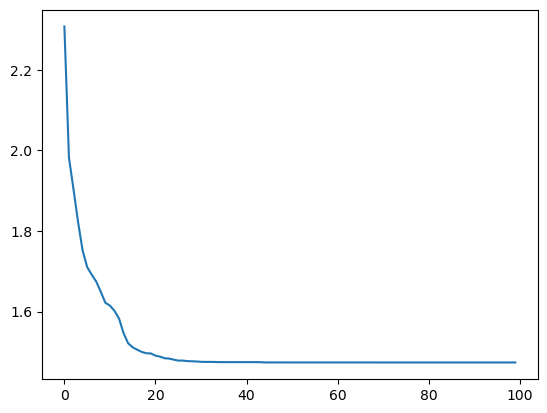

In [100]:
plt.plot(losses)
plt.show()

In [101]:
with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))

In [102]:
print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

model의 output은 :  [0.0000000e+00 1.0000000e+00 0.0000000e+00 0.0000000e+00 3.6337767e-36
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]
argmax를 한 후의 output은 1
accuracy는 0.9666666666666667


시도3\
활성화함수 : ReLu \
optimizer : RMSprop 사용 lr= 0.03 \
accuracy : 0.196 ??

In [103]:
from sklearn.datasets import load_digits
data=load_digits()

In [104]:
input = data.data 
output = data.target 

In [105]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device == "cuda":
  torch.cuda.manual_seed_all(777)

In [106]:
x_train, x_test, y_train, y_test = train_test_split(input, output, test_size = 0.3, random_state = 42, stratify= data.target, shuffle = True)

x_train = torch.FloatTensor(x_train).to(device)
y_train = torch.LongTensor(y_train).to(device)
x_test = torch.FloatTensor(x_test)
y_test = torch.LongTensor(y_test)

In [107]:
from torch.utils.data import Dataset
class CustomDataset(Dataset):
  def __init__(self): # 데이터셋의 입력 데이터/ 출력 데이터 초기화
    self.x_data = x_train
    self.y_data = [[y] for y in y_train]
#  데이터셋의 전처리를 해주는 부분

  def __len__(self):
    return len(self.x_data)
#  데이터셋의 길이. 즉, 총 샘플의 수를 적어주는 부분

  def __getitem__(self, idx): # 특정 인덱스에 해당하는
    x = torch.FloatTensor(self.x_data[idx]).to(device)
    y = torch.LongTensor(self.y_data[idx]).to(device)
#  데이터셋에서 특정 1개의 샘플을 가져오는 함수

    return x,y

In [108]:
batch_size = 8

dataset = CustomDataset() # 객체를 생성해서 커스텀데이터셋 만듬
dataloader = DataLoader(dataset, batch_size=batch_size) # 데이터셋, 배치 크기 전달

In [109]:
# input_layer와 hidden_layer의 노드 개수를 어떻게 바꿔줘야할까?
# hidden layer/neuron 수를 바꾸기

model = nn.Sequential(
          nn.Linear(64,1257, bias=True),
          nn.ReLU(),
          nn.Linear(1257,30, bias=True),
          nn.ReLU(),
          nn.Linear(30,15, bias=True),
          nn.ReLU(),
          nn.Linear(15,10, bias=True),

          nn.Softmax()
          ).to(device)

In [110]:
class Model(torch.nn.Module):

  def __init__(self):
    super(Model, self).__init__()
    self.layer1 = nn.Sequential(
          nn.Linear(64,1257, bias=True), # input_layer = 30, hidden_layer1 = 398
          nn.ReLU(),
        nn.BatchNorm1d(1257)
    )
  # activation function 이용
  #   nn.ReLU()
  #   nn.tanH()
  #   https://pytorch.org/docs/stable/nn.html 그 외에도 여기서 확인 가능함
  #   파라미터가 필요하지 않다는 것이 특징

  # batch normazliation 1d, 파라미터 값으로 vector의 길이를 전해줌
  # 추후에 이미지를 다루게 된다면, 그때는 batch normalization 2d를 이용하게 됨
  # 그때는 파라미터 값으로 채널, 가로, 세로 길이를 전달해주게 됨

    self.layer2 = nn.Sequential(
          nn.Linear(1257,30, bias=True), # hidden_layer1 = 398, hidden_layer2 = 30
        nn.ReLU()
    )
    self.layer3 = nn.Sequential(
          nn.Linear(30,15, bias=True), # hidden_layer1 = 30, hidden_layer2 = 15

        nn.ReLU()
    )

    self.layer4 = nn.Sequential(
          nn.Linear(15, 10, bias=True), # hidden_layer3 = 15, output_layer = 10

        nn.Softmax()
    )

  def forward(self,x):
    output = self.layer1(x)
    output = self.layer2(output)
    output = self.layer3(output)
    output = self.layer4(output)
    return output

In [111]:
def init_weights(layer):
    if isinstance(layer, nn.Linear):
        torch.nn.init.xavier_uniform(layer.weight)
        layer.bias.data.fill_(0.01)

        #xavier사용
        # Layer의 weight를 어떤 분포를 가지도록 초기화시켜줌+global minimum찾기 위해서

In [112]:
model = Model().to(device)
model.apply(init_weights)

C:\Users\withy\AppData\Local\Temp\ipykernel_8516\2101624760.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(layer.weight)


Model(
  (layer1): Sequential(
    (0): Linear(in_features=64, out_features=1257, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(1257, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=1257, out_features=30, bias=True)
    (1): ReLU()
  )
  (layer3): Sequential(
    (0): Linear(in_features=30, out_features=15, bias=True)
    (1): ReLU()
  )
  (layer4): Sequential(
    (0): Linear(in_features=15, out_features=10, bias=True)
    (1): Softmax(dim=None)
  )
)

In [113]:
print(model)

Model(
  (layer1): Sequential(
    (0): Linear(in_features=64, out_features=1257, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(1257, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=1257, out_features=30, bias=True)
    (1): ReLU()
  )
  (layer3): Sequential(
    (0): Linear(in_features=30, out_features=15, bias=True)
    (1): ReLU()
  )
  (layer4): Sequential(
    (0): Linear(in_features=15, out_features=10, bias=True)
    (1): Softmax(dim=None)
  )
)


In [114]:
loss_fn  = nn.CrossEntropyLoss().to(device)

# 여러가지 optimizer 시도해보기
# lr 바꿔보기

optimizer = optim.RMSprop(model.parameters(), lr= 0.03)

# https://pytorch.org/docs/stable/optim.html#module-torch.optim 페이지 참조
# optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
# sgd 등등

In [115]:
losses = []
for epoch in range(100):

  optimizer.zero_grad()
  hypothesis = model(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())

C:\Users\withy\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


0 2.3077392578125
10 2.2756917476654053
20 2.266242504119873
30 2.2645950317382812
40 2.2638556957244873
50 2.2638556957244873
60 2.2638556957244873
70 2.2638556957244873
80 2.2638556957244873
90 2.2638556957244873


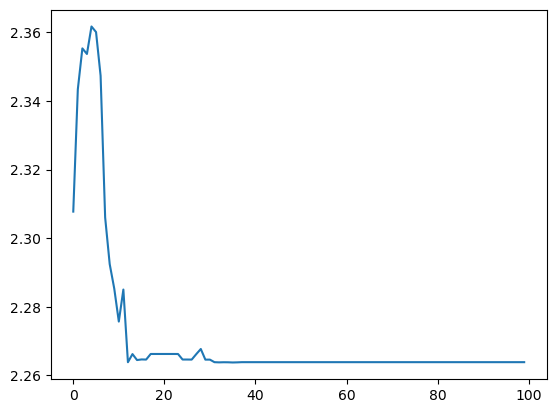

In [116]:
plt.plot(losses)
plt.show()

In [117]:
with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))

In [118]:
print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

model의 output은 :  [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
argmax를 한 후의 output은 2
accuracy는 0.1962962962962963


시도4\
활성화함수 : Sigmoid \
optimizer : RMSprop 사용 lr= 0.03 \
accuracy : 0.866 Loss값이 좀 튄다

In [119]:
from sklearn.datasets import load_digits
data=load_digits()

In [120]:
input = data.data 
output = data.target 

In [121]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device == "cuda":
  torch.cuda.manual_seed_all(777)

In [122]:
x_train, x_test, y_train, y_test = train_test_split(input, output, test_size = 0.3, random_state = 42, stratify= data.target, shuffle = True)

x_train = torch.FloatTensor(x_train).to(device)
y_train = torch.LongTensor(y_train).to(device)
x_test = torch.FloatTensor(x_test)
y_test = torch.LongTensor(y_test)

In [123]:
from torch.utils.data import Dataset
class CustomDataset(Dataset):
  def __init__(self): # 데이터셋의 입력 데이터/ 출력 데이터 초기화
    self.x_data = x_train
    self.y_data = [[y] for y in y_train]
#  데이터셋의 전처리를 해주는 부분

  def __len__(self):
    return len(self.x_data)
#  데이터셋의 길이. 즉, 총 샘플의 수를 적어주는 부분

  def __getitem__(self, idx): # 특정 인덱스에 해당하는
    x = torch.FloatTensor(self.x_data[idx]).to(device)
    y = torch.LongTensor(self.y_data[idx]).to(device)
#  데이터셋에서 특정 1개의 샘플을 가져오는 함수

    return x,y

In [124]:
batch_size = 8

dataset = CustomDataset() # 객체를 생성해서 커스텀데이터셋 만듬
dataloader = DataLoader(dataset, batch_size=batch_size) # 데이터셋, 배치 크기 전달

In [125]:
# input_layer와 hidden_layer의 노드 개수를 어떻게 바꿔줘야할까?
# hidden layer/neuron 수를 바꾸기

model = nn.Sequential(
          nn.Linear(64,1257, bias=True),
          nn.Sigmoid(),
          nn.Linear(1257,30, bias=True),
          nn.Sigmoid(),
          nn.Linear(30,15, bias=True),
          nn.Sigmoid(),
          nn.Linear(15,10, bias=True),

          nn.Softmax()
          ).to(device)

In [126]:
class Model(torch.nn.Module):

  def __init__(self):
    super(Model, self).__init__()
    self.layer1 = nn.Sequential(
          nn.Linear(64,1257, bias=True), # input_layer = 30, hidden_layer1 = 398
          nn.Sigmoid(),
        nn.BatchNorm1d(1257)
    )
  # activation function 이용
  #   nn.ReLU()
  #   nn.tanH()
  #   https://pytorch.org/docs/stable/nn.html 그 외에도 여기서 확인 가능함
  #   파라미터가 필요하지 않다는 것이 특징

  # batch normazliation 1d, 파라미터 값으로 vector의 길이를 전해줌
  # 추후에 이미지를 다루게 된다면, 그때는 batch normalization 2d를 이용하게 됨
  # 그때는 파라미터 값으로 채널, 가로, 세로 길이를 전달해주게 됨

    self.layer2 = nn.Sequential(
          nn.Linear(1257,30, bias=True), # hidden_layer1 = 398, hidden_layer2 = 30
        nn.Sigmoid()
    )
    self.layer3 = nn.Sequential(
          nn.Linear(30,15, bias=True), # hidden_layer1 = 30, hidden_layer2 = 15

        nn.Sigmoid()
    )

    self.layer4 = nn.Sequential(
          nn.Linear(15, 10, bias=True), # hidden_layer3 = 15, output_layer = 10

        nn.Softmax()
    )

  def forward(self,x):
    output = self.layer1(x)
    output = self.layer2(output)
    output = self.layer3(output)
    output = self.layer4(output)
    return output

In [127]:
def init_weights(layer):
    if isinstance(layer, nn.Linear):
        torch.nn.init.xavier_uniform(layer.weight)
        layer.bias.data.fill_(0.01)

        #xavier사용
        # Layer의 weight를 어떤 분포를 가지도록 초기화시켜줌+global minimum찾기 위해서

In [128]:
model = Model().to(device)
model.apply(init_weights)

C:\Users\withy\AppData\Local\Temp\ipykernel_8516\2101624760.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(layer.weight)


Model(
  (layer1): Sequential(
    (0): Linear(in_features=64, out_features=1257, bias=True)
    (1): Sigmoid()
    (2): BatchNorm1d(1257, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=1257, out_features=30, bias=True)
    (1): Sigmoid()
  )
  (layer3): Sequential(
    (0): Linear(in_features=30, out_features=15, bias=True)
    (1): Sigmoid()
  )
  (layer4): Sequential(
    (0): Linear(in_features=15, out_features=10, bias=True)
    (1): Softmax(dim=None)
  )
)

In [129]:
print(model)

Model(
  (layer1): Sequential(
    (0): Linear(in_features=64, out_features=1257, bias=True)
    (1): Sigmoid()
    (2): BatchNorm1d(1257, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=1257, out_features=30, bias=True)
    (1): Sigmoid()
  )
  (layer3): Sequential(
    (0): Linear(in_features=30, out_features=15, bias=True)
    (1): Sigmoid()
  )
  (layer4): Sequential(
    (0): Linear(in_features=15, out_features=10, bias=True)
    (1): Softmax(dim=None)
  )
)


In [130]:
loss_fn  = nn.CrossEntropyLoss().to(device)

# 여러가지 optimizer 시도해보기
# lr 바꿔보기

optimizer = optim.RMSprop(model.parameters(), lr= 0.03)

# https://pytorch.org/docs/stable/optim.html#module-torch.optim 페이지 참조
# optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
# sgd 등등

In [131]:
losses = []
for epoch in range(100):

  optimizer.zero_grad()
  hypothesis = model(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())

C:\Users\withy\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


0 2.3041915893554688
10 2.1282780170440674
20 1.8243850469589233
30 1.728922724723816
40 1.6757092475891113
50 1.6694341897964478
60 1.6750253438949585
70 1.6200743913650513
80 1.599284052848816
90 1.579537034034729


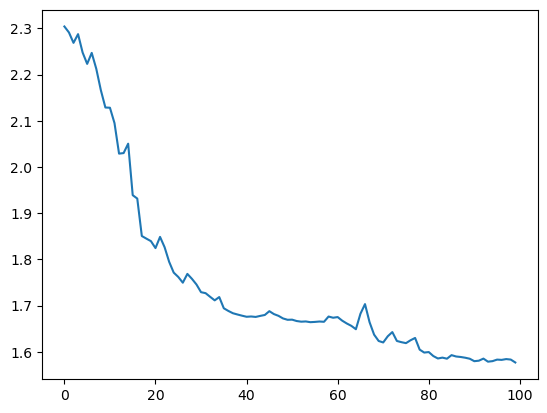

In [132]:
plt.plot(losses)
plt.show()

In [133]:
with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))

In [134]:
print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

model의 output은 :  [3.6251240e-05 9.8866510e-01 6.6554928e-03 3.0747404e-05 2.3599899e-04
 1.3907398e-05 3.4659267e-03 1.1151651e-06 7.1138924e-04 1.8411988e-04]
argmax를 한 후의 output은 1
accuracy는 0.8666666666666667


시도5\
활성화함수 : tanh \
optimizer : Adagrad 사용 lr= 0.03 \
accuracy : 0.9796

In [135]:
from sklearn.datasets import load_digits
data=load_digits()

In [136]:
input = data.data 
output = data.target 

In [137]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device == "cuda":
  torch.cuda.manual_seed_all(777)

In [138]:
x_train, x_test, y_train, y_test = train_test_split(input, output, test_size = 0.3, random_state = 42, stratify= data.target, shuffle = True)

x_train = torch.FloatTensor(x_train).to(device)
y_train = torch.LongTensor(y_train).to(device)
x_test = torch.FloatTensor(x_test)
y_test = torch.LongTensor(y_test)

In [139]:
from torch.utils.data import Dataset
class CustomDataset(Dataset):
  def __init__(self): # 데이터셋의 입력 데이터/ 출력 데이터 초기화
    self.x_data = x_train
    self.y_data = [[y] for y in y_train]
#  데이터셋의 전처리를 해주는 부분

  def __len__(self):
    return len(self.x_data)
#  데이터셋의 길이. 즉, 총 샘플의 수를 적어주는 부분

  def __getitem__(self, idx): # 특정 인덱스에 해당하는
    x = torch.FloatTensor(self.x_data[idx]).to(device)
    y = torch.LongTensor(self.y_data[idx]).to(device)
#  데이터셋에서 특정 1개의 샘플을 가져오는 함수

    return x,y

In [140]:
batch_size = 8

dataset = CustomDataset() # 객체를 생성해서 커스텀데이터셋 만듬
dataloader = DataLoader(dataset, batch_size=batch_size) # 데이터셋, 배치 크기 전달

In [141]:
# input_layer와 hidden_layer의 노드 개수를 어떻게 바꿔줘야할까?
# hidden layer/neuron 수를 바꾸기

model = nn.Sequential(
          nn.Linear(64,1257, bias=True),
          nn.Tanh(),
          nn.Linear(1257,30, bias=True),
          nn.Tanh(),
          nn.Linear(30,15, bias=True),
          nn.Tanh(),
          nn.Linear(15,10, bias=True),

          nn.Softmax()
          ).to(device)

In [142]:
class Model(torch.nn.Module):

  def __init__(self):
    super(Model, self).__init__()
    self.layer1 = nn.Sequential(
          nn.Linear(64,1257, bias=True), # input_layer = 30, hidden_layer1 = 398
          nn.Tanh(),
        nn.BatchNorm1d(1257)
    )
  # activation function 이용
  #   nn.ReLU()
  #   nn.tanH()
  #   https://pytorch.org/docs/stable/nn.html 그 외에도 여기서 확인 가능함
  #   파라미터가 필요하지 않다는 것이 특징

  # batch normazliation 1d, 파라미터 값으로 vector의 길이를 전해줌
  # 추후에 이미지를 다루게 된다면, 그때는 batch normalization 2d를 이용하게 됨
  # 그때는 파라미터 값으로 채널, 가로, 세로 길이를 전달해주게 됨

    self.layer2 = nn.Sequential(
          nn.Linear(1257,30, bias=True), # hidden_layer1 = 398, hidden_layer2 = 30
        nn.Tanh()
    )
    self.layer3 = nn.Sequential(
          nn.Linear(30,15, bias=True), # hidden_layer1 = 30, hidden_layer2 = 15

        nn.Tanh()
    )

    self.layer4 = nn.Sequential(
          nn.Linear(15, 10, bias=True), # hidden_layer3 = 15, output_layer = 10

        nn.Softmax()
    )

  def forward(self,x):
    output = self.layer1(x)
    output = self.layer2(output)
    output = self.layer3(output)
    output = self.layer4(output)
    return output

In [143]:
def init_weights(layer):
    if isinstance(layer, nn.Linear):
        torch.nn.init.xavier_uniform(layer.weight)
        layer.bias.data.fill_(0.01)

        #xavier사용
        # Layer의 weight를 어떤 분포를 가지도록 초기화시켜줌+global minimum찾기 위해서

In [144]:
model = Model().to(device)
model.apply(init_weights)

C:\Users\withy\AppData\Local\Temp\ipykernel_8516\2101624760.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(layer.weight)


Model(
  (layer1): Sequential(
    (0): Linear(in_features=64, out_features=1257, bias=True)
    (1): Tanh()
    (2): BatchNorm1d(1257, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=1257, out_features=30, bias=True)
    (1): Tanh()
  )
  (layer3): Sequential(
    (0): Linear(in_features=30, out_features=15, bias=True)
    (1): Tanh()
  )
  (layer4): Sequential(
    (0): Linear(in_features=15, out_features=10, bias=True)
    (1): Softmax(dim=None)
  )
)

In [145]:
print(model)

Model(
  (layer1): Sequential(
    (0): Linear(in_features=64, out_features=1257, bias=True)
    (1): Tanh()
    (2): BatchNorm1d(1257, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=1257, out_features=30, bias=True)
    (1): Tanh()
  )
  (layer3): Sequential(
    (0): Linear(in_features=30, out_features=15, bias=True)
    (1): Tanh()
  )
  (layer4): Sequential(
    (0): Linear(in_features=15, out_features=10, bias=True)
    (1): Softmax(dim=None)
  )
)


In [146]:
loss_fn  = nn.CrossEntropyLoss().to(device)

# 여러가지 optimizer 시도해보기
# lr 바꿔보기

optimizer = optim.Adagrad(model.parameters(), lr= 0.03)

# https://pytorch.org/docs/stable/optim.html#module-torch.optim 페이지 참조
# optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
# sgd 등등

In [147]:
losses = []
for epoch in range(100):

  optimizer.zero_grad()
  hypothesis = model(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())

C:\Users\withy\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


0 2.3084206581115723
10 1.6198829412460327
20 1.5161141157150269
30 1.4959362745285034
40 1.4866430759429932
50 1.4813218116760254
60 1.4778348207473755
70 1.4753636121749878
80 1.473528265953064
90 1.472108006477356


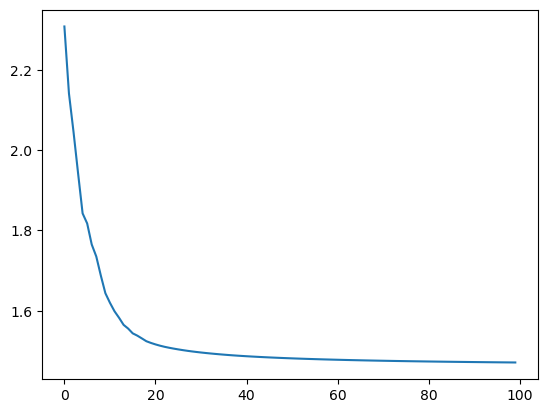

In [148]:
plt.plot(losses)
plt.show()

In [149]:
with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))

In [150]:
print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

model의 output은 :  [9.3279715e-04 9.9340457e-01 9.2128722e-04 2.4011221e-03 8.7871117e-04
 1.7373363e-04 8.6927845e-05 3.6987464e-04 7.9419889e-04 3.6861420e-05]
argmax를 한 후의 output은 1
accuracy는 0.9796296296296296


시도6\
활성화함수 : tanh \
optimizer : Adam 사용 lr= 0.03 \
accuracy : 0.9759

In [151]:
from sklearn.datasets import load_digits
data=load_digits()

In [152]:
input = data.data 
output = data.target 

In [153]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device == "cuda":
  torch.cuda.manual_seed_all(777)

In [154]:
x_train, x_test, y_train, y_test = train_test_split(input, output, test_size = 0.3, random_state = 42, stratify= data.target, shuffle = True)

x_train = torch.FloatTensor(x_train).to(device)
y_train = torch.LongTensor(y_train).to(device)
x_test = torch.FloatTensor(x_test)
y_test = torch.LongTensor(y_test)

In [155]:
from torch.utils.data import Dataset
class CustomDataset(Dataset):
  def __init__(self): # 데이터셋의 입력 데이터/ 출력 데이터 초기화
    self.x_data = x_train
    self.y_data = [[y] for y in y_train]
#  데이터셋의 전처리를 해주는 부분

  def __len__(self):
    return len(self.x_data)
#  데이터셋의 길이. 즉, 총 샘플의 수를 적어주는 부분

  def __getitem__(self, idx): # 특정 인덱스에 해당하는
    x = torch.FloatTensor(self.x_data[idx]).to(device)
    y = torch.LongTensor(self.y_data[idx]).to(device)
#  데이터셋에서 특정 1개의 샘플을 가져오는 함수

    return x,y

In [156]:
batch_size = 8

dataset = CustomDataset() # 객체를 생성해서 커스텀데이터셋 만듬
dataloader = DataLoader(dataset, batch_size=batch_size) # 데이터셋, 배치 크기 전달

In [157]:
# input_layer와 hidden_layer의 노드 개수를 어떻게 바꿔줘야할까?
# hidden layer/neuron 수를 바꾸기

model = nn.Sequential(
          nn.Linear(64,1257, bias=True),
          nn.Tanh(),
          nn.Linear(1257,30, bias=True),
          nn.Tanh(),
          nn.Linear(30,15, bias=True),
          nn.Tanh(),
          nn.Linear(15,10, bias=True),

          nn.Softmax()
          ).to(device)

In [158]:
class Model(torch.nn.Module):

  def __init__(self):
    super(Model, self).__init__()
    self.layer1 = nn.Sequential(
          nn.Linear(64,1257, bias=True), # input_layer = 30, hidden_layer1 = 398
          nn.Tanh(),
        nn.BatchNorm1d(1257)
    )
  # activation function 이용
  #   nn.ReLU()
  #   nn.tanH()
  #   https://pytorch.org/docs/stable/nn.html 그 외에도 여기서 확인 가능함
  #   파라미터가 필요하지 않다는 것이 특징

  # batch normazliation 1d, 파라미터 값으로 vector의 길이를 전해줌
  # 추후에 이미지를 다루게 된다면, 그때는 batch normalization 2d를 이용하게 됨
  # 그때는 파라미터 값으로 채널, 가로, 세로 길이를 전달해주게 됨

    self.layer2 = nn.Sequential(
          nn.Linear(1257,30, bias=True), # hidden_layer1 = 398, hidden_layer2 = 30
        nn.Tanh()
    )
    self.layer3 = nn.Sequential(
          nn.Linear(30,15, bias=True), # hidden_layer1 = 30, hidden_layer2 = 15

        nn.Tanh()
    )

    self.layer4 = nn.Sequential(
          nn.Linear(15, 10, bias=True), # hidden_layer3 = 15, output_layer = 10

        nn.Softmax()
    )

  def forward(self,x):
    output = self.layer1(x)
    output = self.layer2(output)
    output = self.layer3(output)
    output = self.layer4(output)
    return output

In [159]:
def init_weights(layer):
    if isinstance(layer, nn.Linear):
        torch.nn.init.xavier_uniform(layer.weight)
        layer.bias.data.fill_(0.01)

        #xavier사용
        # Layer의 weight를 어떤 분포를 가지도록 초기화시켜줌+global minimum찾기 위해서

In [160]:
model = Model().to(device)
model.apply(init_weights)

C:\Users\withy\AppData\Local\Temp\ipykernel_8516\2101624760.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(layer.weight)


Model(
  (layer1): Sequential(
    (0): Linear(in_features=64, out_features=1257, bias=True)
    (1): Tanh()
    (2): BatchNorm1d(1257, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=1257, out_features=30, bias=True)
    (1): Tanh()
  )
  (layer3): Sequential(
    (0): Linear(in_features=30, out_features=15, bias=True)
    (1): Tanh()
  )
  (layer4): Sequential(
    (0): Linear(in_features=15, out_features=10, bias=True)
    (1): Softmax(dim=None)
  )
)

In [161]:
print(model)

Model(
  (layer1): Sequential(
    (0): Linear(in_features=64, out_features=1257, bias=True)
    (1): Tanh()
    (2): BatchNorm1d(1257, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=1257, out_features=30, bias=True)
    (1): Tanh()
  )
  (layer3): Sequential(
    (0): Linear(in_features=30, out_features=15, bias=True)
    (1): Tanh()
  )
  (layer4): Sequential(
    (0): Linear(in_features=15, out_features=10, bias=True)
    (1): Softmax(dim=None)
  )
)


In [162]:
loss_fn  = nn.CrossEntropyLoss().to(device)

# 여러가지 optimizer 시도해보기
# lr 바꿔보기

optimizer = optim.Adam(model.parameters(), lr= 0.03)

# https://pytorch.org/docs/stable/optim.html#module-torch.optim 페이지 참조
# optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
# sgd 등등

In [163]:
losses = []
for epoch in range(100):

  optimizer.zero_grad()
  hypothesis = model(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())

C:\Users\withy\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


0 2.3084206581115723
10 1.5291314125061035
20 1.4714449644088745
30 1.4653611183166504
40 1.4642572402954102
50 1.4635111093521118
60 1.4633351564407349
70 1.4632506370544434
80 1.462520956993103
90 1.4624052047729492


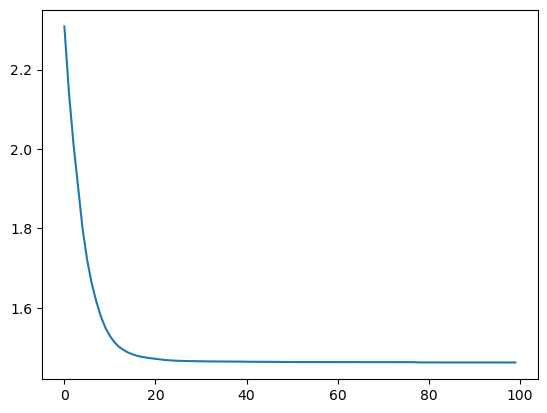

In [164]:
plt.plot(losses)
plt.show()

In [165]:
with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))

In [166]:
print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

model의 output은 :  [3.9023773e-05 9.9967301e-01 9.7897246e-05 1.3140001e-04 2.7589418e-05
 3.8759211e-07 1.4143217e-06 5.9066851e-06 2.3223514e-05 1.4468668e-07]
argmax를 한 후의 output은 1
accuracy는 0.9740740740740741


시도7\
활성화함수 : tanh \
optimizer : SGD 사용 lr= 0.03 \
accuracy : 0.8722

In [167]:
from sklearn.datasets import load_digits
data=load_digits()

In [168]:
input = data.data 
output = data.target 

In [169]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device == "cuda":
  torch.cuda.manual_seed_all(777)

In [170]:
x_train, x_test, y_train, y_test = train_test_split(input, output, test_size = 0.3, random_state = 42, stratify= data.target, shuffle = True)

x_train = torch.FloatTensor(x_train).to(device)
y_train = torch.LongTensor(y_train).to(device)
x_test = torch.FloatTensor(x_test)
y_test = torch.LongTensor(y_test)

In [171]:
from torch.utils.data import Dataset
class CustomDataset(Dataset):
  def __init__(self): # 데이터셋의 입력 데이터/ 출력 데이터 초기화
    self.x_data = x_train
    self.y_data = [[y] for y in y_train]
#  데이터셋의 전처리를 해주는 부분

  def __len__(self):
    return len(self.x_data)
#  데이터셋의 길이. 즉, 총 샘플의 수를 적어주는 부분

  def __getitem__(self, idx): # 특정 인덱스에 해당하는
    x = torch.FloatTensor(self.x_data[idx]).to(device)
    y = torch.LongTensor(self.y_data[idx]).to(device)
#  데이터셋에서 특정 1개의 샘플을 가져오는 함수

    return x,y

In [172]:
batch_size = 8

dataset = CustomDataset() # 객체를 생성해서 커스텀데이터셋 만듬
dataloader = DataLoader(dataset, batch_size=batch_size) # 데이터셋, 배치 크기 전달

In [173]:
# input_layer와 hidden_layer의 노드 개수를 어떻게 바꿔줘야할까?
# hidden layer/neuron 수를 바꾸기

model = nn.Sequential(
          nn.Linear(64,1257, bias=True),
          nn.Tanh(),
          nn.Linear(1257,30, bias=True),
          nn.Tanh(),
          nn.Linear(30,15, bias=True),
          nn.Tanh(),
          nn.Linear(15,10, bias=True),

          nn.Softmax()
          ).to(device)

In [174]:
class Model(torch.nn.Module):

  def __init__(self):
    super(Model, self).__init__()
    self.layer1 = nn.Sequential(
          nn.Linear(64,1257, bias=True), # input_layer = 30, hidden_layer1 = 398
          nn.Tanh(),
        nn.BatchNorm1d(1257)
    )
  # activation function 이용
  #   nn.ReLU()
  #   nn.tanH()
  #   https://pytorch.org/docs/stable/nn.html 그 외에도 여기서 확인 가능함
  #   파라미터가 필요하지 않다는 것이 특징

  # batch normazliation 1d, 파라미터 값으로 vector의 길이를 전해줌
  # 추후에 이미지를 다루게 된다면, 그때는 batch normalization 2d를 이용하게 됨
  # 그때는 파라미터 값으로 채널, 가로, 세로 길이를 전달해주게 됨

    self.layer2 = nn.Sequential(
          nn.Linear(1257,30, bias=True), # hidden_layer1 = 398, hidden_layer2 = 30
        nn.Tanh()
    )
    self.layer3 = nn.Sequential(
          nn.Linear(30,15, bias=True), # hidden_layer1 = 30, hidden_layer2 = 15

        nn.Tanh()
    )

    self.layer4 = nn.Sequential(
          nn.Linear(15, 10, bias=True), # hidden_layer3 = 15, output_layer = 10

        nn.Softmax()
    )

  def forward(self,x):
    output = self.layer1(x)
    output = self.layer2(output)
    output = self.layer3(output)
    output = self.layer4(output)
    return output

In [175]:
def init_weights(layer):
    if isinstance(layer, nn.Linear):
        torch.nn.init.xavier_uniform(layer.weight)
        layer.bias.data.fill_(0.01)

        #xavier사용
        # Layer의 weight를 어떤 분포를 가지도록 초기화시켜줌+global minimum찾기 위해서

In [176]:
model = Model().to(device)
model.apply(init_weights)

C:\Users\withy\AppData\Local\Temp\ipykernel_8516\2101624760.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(layer.weight)


Model(
  (layer1): Sequential(
    (0): Linear(in_features=64, out_features=1257, bias=True)
    (1): Tanh()
    (2): BatchNorm1d(1257, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=1257, out_features=30, bias=True)
    (1): Tanh()
  )
  (layer3): Sequential(
    (0): Linear(in_features=30, out_features=15, bias=True)
    (1): Tanh()
  )
  (layer4): Sequential(
    (0): Linear(in_features=15, out_features=10, bias=True)
    (1): Softmax(dim=None)
  )
)

In [177]:
print(model)

Model(
  (layer1): Sequential(
    (0): Linear(in_features=64, out_features=1257, bias=True)
    (1): Tanh()
    (2): BatchNorm1d(1257, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=1257, out_features=30, bias=True)
    (1): Tanh()
  )
  (layer3): Sequential(
    (0): Linear(in_features=30, out_features=15, bias=True)
    (1): Tanh()
  )
  (layer4): Sequential(
    (0): Linear(in_features=15, out_features=10, bias=True)
    (1): Softmax(dim=None)
  )
)


In [178]:
loss_fn  = nn.CrossEntropyLoss().to(device)

# 여러가지 optimizer 시도해보기
# lr 바꿔보기

optimizer = optim.SGD(model.parameters(), lr= 0.03)

# https://pytorch.org/docs/stable/optim.html#module-torch.optim 페이지 참조
# optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
# sgd 등등

In [179]:
losses = []
for epoch in range(100):

  optimizer.zero_grad()
  hypothesis = model(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())

C:\Users\withy\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


0 2.3084206581115723
10 2.2139651775360107
20 2.1122078895568848
30 2.055302381515503
40 2.016390323638916
50 1.985312581062317
60 1.9586917161941528
70 1.934801459312439
80 1.9128446578979492
90 1.8924846649169922


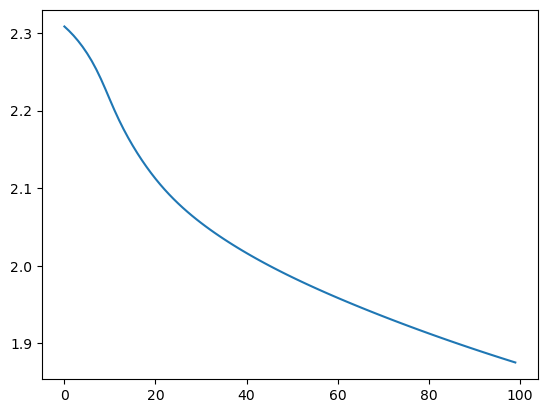

In [180]:
plt.plot(losses)
plt.show()

In [181]:
with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))

In [182]:
print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

model의 output은 :  [0.05748468 0.60773253 0.10230715 0.0294139  0.03951782 0.01819618
 0.06125912 0.01315766 0.05495014 0.01598091]
argmax를 한 후의 output은 1
accuracy는 0.8722222222222222


시도8\
활성화함수 : Sigmoid \
optimizer : SGD 사용 lr= 0.03 \
accuracy : 0.1018 ???

In [183]:
from sklearn.datasets import load_digits
data=load_digits()

In [184]:
input = data.data 
output = data.target 

In [185]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device == "cuda":
  torch.cuda.manual_seed_all(777)

In [186]:
x_train, x_test, y_train, y_test = train_test_split(input, output, test_size = 0.3, random_state = 42, stratify= data.target, shuffle = True)

x_train = torch.FloatTensor(x_train).to(device)
y_train = torch.LongTensor(y_train).to(device)
x_test = torch.FloatTensor(x_test)
y_test = torch.LongTensor(y_test)

In [187]:
from torch.utils.data import Dataset
class CustomDataset(Dataset):
  def __init__(self): # 데이터셋의 입력 데이터/ 출력 데이터 초기화
    self.x_data = x_train
    self.y_data = [[y] for y in y_train]
#  데이터셋의 전처리를 해주는 부분

  def __len__(self):
    return len(self.x_data)
#  데이터셋의 길이. 즉, 총 샘플의 수를 적어주는 부분

  def __getitem__(self, idx): # 특정 인덱스에 해당하는
    x = torch.FloatTensor(self.x_data[idx]).to(device)
    y = torch.LongTensor(self.y_data[idx]).to(device)
#  데이터셋에서 특정 1개의 샘플을 가져오는 함수

    return x,y

In [188]:
batch_size = 8

dataset = CustomDataset() # 객체를 생성해서 커스텀데이터셋 만듬
dataloader = DataLoader(dataset, batch_size=batch_size) # 데이터셋, 배치 크기 전달

In [189]:
# input_layer와 hidden_layer의 노드 개수를 어떻게 바꿔줘야할까?
# hidden layer/neuron 수를 바꾸기

model = nn.Sequential(
          nn.Linear(64,1257, bias=True),
          nn.Sigmoid(),
          nn.Linear(1257,30, bias=True),
          nn.Sigmoid(),
          nn.Linear(30,15, bias=True),
          nn.Sigmoid(),
          nn.Linear(15,10, bias=True),

          nn.Softmax()
          ).to(device)

In [190]:
class Model(torch.nn.Module):

  def __init__(self):
    super(Model, self).__init__()
    self.layer1 = nn.Sequential(
          nn.Linear(64,1257, bias=True), # input_layer = 30, hidden_layer1 = 398
          nn.Sigmoid(),
        nn.BatchNorm1d(1257)
    )
  # activation function 이용
  #   nn.ReLU()
  #   nn.tanH()
  #   https://pytorch.org/docs/stable/nn.html 그 외에도 여기서 확인 가능함
  #   파라미터가 필요하지 않다는 것이 특징

  # batch normazliation 1d, 파라미터 값으로 vector의 길이를 전해줌
  # 추후에 이미지를 다루게 된다면, 그때는 batch normalization 2d를 이용하게 됨
  # 그때는 파라미터 값으로 채널, 가로, 세로 길이를 전달해주게 됨

    self.layer2 = nn.Sequential(
          nn.Linear(1257,30, bias=True), # hidden_layer1 = 398, hidden_layer2 = 30
        nn.Sigmoid()
    )
    self.layer3 = nn.Sequential(
          nn.Linear(30,15, bias=True), # hidden_layer1 = 30, hidden_layer2 = 15

        nn.Sigmoid()
    )

    self.layer4 = nn.Sequential(
          nn.Linear(15, 10, bias=True), # hidden_layer3 = 15, output_layer = 10

        nn.Softmax()
    )

  def forward(self,x):
    output = self.layer1(x)
    output = self.layer2(output)
    output = self.layer3(output)
    output = self.layer4(output)
    return output

In [191]:
def init_weights(layer):
    if isinstance(layer, nn.Linear):
        torch.nn.init.xavier_uniform(layer.weight)
        layer.bias.data.fill_(0.01)

        #xavier사용
        # Layer의 weight를 어떤 분포를 가지도록 초기화시켜줌+global minimum찾기 위해서

In [192]:
model = Model().to(device)
model.apply(init_weights)

C:\Users\withy\AppData\Local\Temp\ipykernel_8516\2101624760.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(layer.weight)


Model(
  (layer1): Sequential(
    (0): Linear(in_features=64, out_features=1257, bias=True)
    (1): Sigmoid()
    (2): BatchNorm1d(1257, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=1257, out_features=30, bias=True)
    (1): Sigmoid()
  )
  (layer3): Sequential(
    (0): Linear(in_features=30, out_features=15, bias=True)
    (1): Sigmoid()
  )
  (layer4): Sequential(
    (0): Linear(in_features=15, out_features=10, bias=True)
    (1): Softmax(dim=None)
  )
)

In [193]:
print(model)

Model(
  (layer1): Sequential(
    (0): Linear(in_features=64, out_features=1257, bias=True)
    (1): Sigmoid()
    (2): BatchNorm1d(1257, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=1257, out_features=30, bias=True)
    (1): Sigmoid()
  )
  (layer3): Sequential(
    (0): Linear(in_features=30, out_features=15, bias=True)
    (1): Sigmoid()
  )
  (layer4): Sequential(
    (0): Linear(in_features=15, out_features=10, bias=True)
    (1): Softmax(dim=None)
  )
)


In [194]:
loss_fn  = nn.CrossEntropyLoss().to(device)

# 여러가지 optimizer 시도해보기
# lr 바꿔보기

optimizer = optim.SGD(model.parameters(), lr= 0.03)

# https://pytorch.org/docs/stable/optim.html#module-torch.optim 페이지 참조
# optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
# sgd 등등

In [195]:
losses = []
for epoch in range(100):

  optimizer.zero_grad()
  hypothesis = model(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())

C:\Users\withy\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


0 2.3041915893554688
10 2.3032777309417725
20 2.302344560623169
30 2.3013899326324463
40 2.3004140853881836
50 2.299417018890381
60 2.298398733139038
70 2.29736065864563
80 2.2963078022003174
90 2.2952466011047363


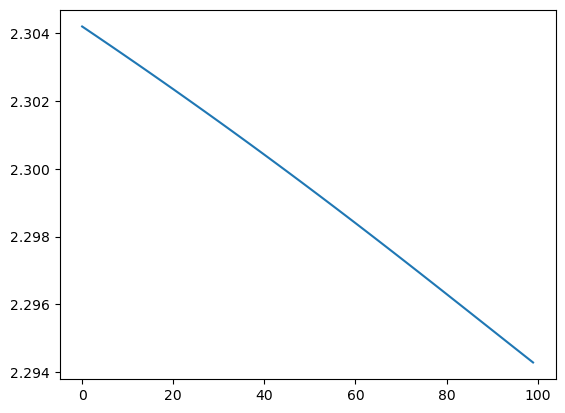

In [196]:
plt.plot(losses)
plt.show()

In [197]:
with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))

In [198]:
print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

model의 output은 :  [0.06043788 0.1107979  0.08877682 0.04458142 0.08100642 0.18553166
 0.1346074  0.13478224 0.08354851 0.07592972]
argmax를 한 후의 output은 5
accuracy는 0.10185185185185185


시도9\
활성화함수 : Sigmoid \
optimizer : Adagrad 사용 lr= 0.03 \
accuracy : 0.9814

In [199]:
from sklearn.datasets import load_digits
data=load_digits()

In [200]:
input = data.data 
output = data.target 

In [201]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device == "cuda":
  torch.cuda.manual_seed_all(777)

In [202]:
x_train, x_test, y_train, y_test = train_test_split(input, output, test_size = 0.3, random_state = 42, stratify= data.target, shuffle = True)

x_train = torch.FloatTensor(x_train).to(device)
y_train = torch.LongTensor(y_train).to(device)
x_test = torch.FloatTensor(x_test)
y_test = torch.LongTensor(y_test)

In [203]:
from torch.utils.data import Dataset
class CustomDataset(Dataset):
  def __init__(self): # 데이터셋의 입력 데이터/ 출력 데이터 초기화
    self.x_data = x_train
    self.y_data = [[y] for y in y_train]
#  데이터셋의 전처리를 해주는 부분

  def __len__(self):
    return len(self.x_data)
#  데이터셋의 길이. 즉, 총 샘플의 수를 적어주는 부분

  def __getitem__(self, idx): # 특정 인덱스에 해당하는
    x = torch.FloatTensor(self.x_data[idx]).to(device)
    y = torch.LongTensor(self.y_data[idx]).to(device)
#  데이터셋에서 특정 1개의 샘플을 가져오는 함수

    return x,y

In [204]:
batch_size = 8

dataset = CustomDataset() # 객체를 생성해서 커스텀데이터셋 만듬
dataloader = DataLoader(dataset, batch_size=batch_size) # 데이터셋, 배치 크기 전달

In [205]:
# input_layer와 hidden_layer의 노드 개수를 어떻게 바꿔줘야할까?
# hidden layer/neuron 수를 바꾸기

model = nn.Sequential(
          nn.Linear(64,1257, bias=True),
          nn.Sigmoid(),
          nn.Linear(1257,30, bias=True),
          nn.Sigmoid(),
          nn.Linear(30,15, bias=True),
          nn.Sigmoid(),
          nn.Linear(15,10, bias=True),

          nn.Softmax()
          ).to(device)

In [206]:
class Model(torch.nn.Module):

  def __init__(self):
    super(Model, self).__init__()
    self.layer1 = nn.Sequential(
          nn.Linear(64,1257, bias=True), # input_layer = 30, hidden_layer1 = 398
          nn.Sigmoid(),
        nn.BatchNorm1d(1257)
    )
  # activation function 이용
  #   nn.ReLU()
  #   nn.tanH()
  #   https://pytorch.org/docs/stable/nn.html 그 외에도 여기서 확인 가능함
  #   파라미터가 필요하지 않다는 것이 특징

  # batch normazliation 1d, 파라미터 값으로 vector의 길이를 전해줌
  # 추후에 이미지를 다루게 된다면, 그때는 batch normalization 2d를 이용하게 됨
  # 그때는 파라미터 값으로 채널, 가로, 세로 길이를 전달해주게 됨

    self.layer2 = nn.Sequential(
          nn.Linear(1257,30, bias=True), # hidden_layer1 = 398, hidden_layer2 = 30
        nn.Sigmoid()
    )
    self.layer3 = nn.Sequential(
          nn.Linear(30,15, bias=True), # hidden_layer1 = 30, hidden_layer2 = 15

        nn.Sigmoid()
    )

    self.layer4 = nn.Sequential(
          nn.Linear(15, 10, bias=True), # hidden_layer3 = 15, output_layer = 10

        nn.Softmax()
    )

  def forward(self,x):
    output = self.layer1(x)
    output = self.layer2(output)
    output = self.layer3(output)
    output = self.layer4(output)
    return output

In [207]:
def init_weights(layer):
    if isinstance(layer, nn.Linear):
        torch.nn.init.xavier_uniform(layer.weight)
        layer.bias.data.fill_(0.01)

        #xavier사용
        # Layer의 weight를 어떤 분포를 가지도록 초기화시켜줌+global minimum찾기 위해서

In [208]:
model = Model().to(device)
model.apply(init_weights)

C:\Users\withy\AppData\Local\Temp\ipykernel_8516\2101624760.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(layer.weight)


Model(
  (layer1): Sequential(
    (0): Linear(in_features=64, out_features=1257, bias=True)
    (1): Sigmoid()
    (2): BatchNorm1d(1257, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=1257, out_features=30, bias=True)
    (1): Sigmoid()
  )
  (layer3): Sequential(
    (0): Linear(in_features=30, out_features=15, bias=True)
    (1): Sigmoid()
  )
  (layer4): Sequential(
    (0): Linear(in_features=15, out_features=10, bias=True)
    (1): Softmax(dim=None)
  )
)

In [209]:
print(model)

Model(
  (layer1): Sequential(
    (0): Linear(in_features=64, out_features=1257, bias=True)
    (1): Sigmoid()
    (2): BatchNorm1d(1257, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=1257, out_features=30, bias=True)
    (1): Sigmoid()
  )
  (layer3): Sequential(
    (0): Linear(in_features=30, out_features=15, bias=True)
    (1): Sigmoid()
  )
  (layer4): Sequential(
    (0): Linear(in_features=15, out_features=10, bias=True)
    (1): Softmax(dim=None)
  )
)


In [210]:
loss_fn  = nn.CrossEntropyLoss().to(device)

# 여러가지 optimizer 시도해보기
# lr 바꿔보기

optimizer = optim.Adagrad(model.parameters(), lr= 0.03)

# https://pytorch.org/docs/stable/optim.html#module-torch.optim 페이지 참조
# optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
# sgd 등등

In [211]:
losses = []
for epoch in range(100):

  optimizer.zero_grad()
  hypothesis = model(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())

C:\Users\withy\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


0 2.3041915893554688
10 2.0832858085632324
20 1.9182037115097046
30 1.8148518800735474
40 1.7434285879135132
50 1.6961183547973633
60 1.6633251905441284
70 1.6334000825881958
80 1.5975643396377563
90 1.5693556070327759


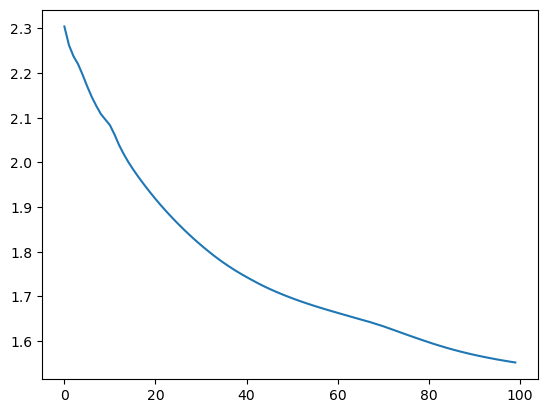

In [212]:
plt.plot(losses)
plt.show()

In [213]:
with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))

In [214]:
print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

model의 output은 :  [1.2902717e-02 9.4418424e-01 9.3341991e-03 6.7041302e-03 3.7883215e-03
 3.5213935e-03 3.8744695e-03 7.2605931e-03 8.1189023e-03 3.1087067e-04]
argmax를 한 후의 output은 1
accuracy는 0.9814814814814815


시도9-1\
활성화함수 : Sigmoid \
optimizer : Adagrad 사용 lr= 0.01 \
accuracy : 0.8926 -> 오히려 감소

In [215]:
from sklearn.datasets import load_digits
data=load_digits()

In [216]:
input = data.data 
output = data.target 

In [217]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device == "cuda":
  torch.cuda.manual_seed_all(777)

In [218]:
x_train, x_test, y_train, y_test = train_test_split(input, output, test_size = 0.3, random_state = 42, stratify= data.target, shuffle = True)

x_train = torch.FloatTensor(x_train).to(device)
y_train = torch.LongTensor(y_train).to(device)
x_test = torch.FloatTensor(x_test)
y_test = torch.LongTensor(y_test)

In [219]:
from torch.utils.data import Dataset
class CustomDataset(Dataset):
  def __init__(self): # 데이터셋의 입력 데이터/ 출력 데이터 초기화
    self.x_data = x_train
    self.y_data = [[y] for y in y_train]
#  데이터셋의 전처리를 해주는 부분

  def __len__(self):
    return len(self.x_data)
#  데이터셋의 길이. 즉, 총 샘플의 수를 적어주는 부분

  def __getitem__(self, idx): # 특정 인덱스에 해당하는
    x = torch.FloatTensor(self.x_data[idx]).to(device)
    y = torch.LongTensor(self.y_data[idx]).to(device)
#  데이터셋에서 특정 1개의 샘플을 가져오는 함수

    return x,y

In [220]:
batch_size = 8

dataset = CustomDataset() # 객체를 생성해서 커스텀데이터셋 만듬
dataloader = DataLoader(dataset, batch_size=batch_size) # 데이터셋, 배치 크기 전달

In [221]:
# input_layer와 hidden_layer의 노드 개수를 어떻게 바꿔줘야할까?
# hidden layer/neuron 수를 바꾸기

model = nn.Sequential(
          nn.Linear(64,1257, bias=True),
          nn.Sigmoid(),
          nn.Linear(1257,30, bias=True),
          nn.Sigmoid(),
          nn.Linear(30,15, bias=True),
          nn.Sigmoid(),
          nn.Linear(15,10, bias=True),

          nn.Softmax()
          ).to(device)

In [222]:
class Model(torch.nn.Module):

  def __init__(self):
    super(Model, self).__init__()
    self.layer1 = nn.Sequential(
          nn.Linear(64,1257, bias=True), # input_layer = 30, hidden_layer1 = 398
          nn.Sigmoid(),
        nn.BatchNorm1d(1257)
    )
  # activation function 이용
  #   nn.ReLU()
  #   nn.tanH()
  #   https://pytorch.org/docs/stable/nn.html 그 외에도 여기서 확인 가능함
  #   파라미터가 필요하지 않다는 것이 특징

  # batch normazliation 1d, 파라미터 값으로 vector의 길이를 전해줌
  # 추후에 이미지를 다루게 된다면, 그때는 batch normalization 2d를 이용하게 됨
  # 그때는 파라미터 값으로 채널, 가로, 세로 길이를 전달해주게 됨

    self.layer2 = nn.Sequential(
          nn.Linear(1257,30, bias=True), # hidden_layer1 = 398, hidden_layer2 = 30
        nn.Sigmoid()
    )
    self.layer3 = nn.Sequential(
          nn.Linear(30,15, bias=True), # hidden_layer1 = 30, hidden_layer2 = 15

        nn.Sigmoid()
    )

    self.layer4 = nn.Sequential(
          nn.Linear(15, 10, bias=True), # hidden_layer3 = 15, output_layer = 10

        nn.Softmax()
    )

  def forward(self,x):
    output = self.layer1(x)
    output = self.layer2(output)
    output = self.layer3(output)
    output = self.layer4(output)
    return output

In [223]:
def init_weights(layer):
    if isinstance(layer, nn.Linear):
        torch.nn.init.xavier_uniform(layer.weight)
        layer.bias.data.fill_(0.01)

        #xavier사용
        # Layer의 weight를 어떤 분포를 가지도록 초기화시켜줌+global minimum찾기 위해서

In [224]:
model = Model().to(device)
model.apply(init_weights)

C:\Users\withy\AppData\Local\Temp\ipykernel_8516\2101624760.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(layer.weight)


Model(
  (layer1): Sequential(
    (0): Linear(in_features=64, out_features=1257, bias=True)
    (1): Sigmoid()
    (2): BatchNorm1d(1257, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=1257, out_features=30, bias=True)
    (1): Sigmoid()
  )
  (layer3): Sequential(
    (0): Linear(in_features=30, out_features=15, bias=True)
    (1): Sigmoid()
  )
  (layer4): Sequential(
    (0): Linear(in_features=15, out_features=10, bias=True)
    (1): Softmax(dim=None)
  )
)

In [225]:
print(model)

Model(
  (layer1): Sequential(
    (0): Linear(in_features=64, out_features=1257, bias=True)
    (1): Sigmoid()
    (2): BatchNorm1d(1257, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=1257, out_features=30, bias=True)
    (1): Sigmoid()
  )
  (layer3): Sequential(
    (0): Linear(in_features=30, out_features=15, bias=True)
    (1): Sigmoid()
  )
  (layer4): Sequential(
    (0): Linear(in_features=15, out_features=10, bias=True)
    (1): Softmax(dim=None)
  )
)


In [226]:
loss_fn  = nn.CrossEntropyLoss().to(device)

# 여러가지 optimizer 시도해보기
# lr 바꿔보기

optimizer = optim.Adagrad(model.parameters(), lr= 0.01)

# https://pytorch.org/docs/stable/optim.html#module-torch.optim 페이지 참조
# optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
# sgd 등등

In [227]:
losses = []
for epoch in range(100):

  optimizer.zero_grad()
  hypothesis = model(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())

C:\Users\withy\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


0 2.3041915893554688
10 2.199411153793335
20 2.157423973083496
30 2.123063325881958
40 2.0922927856445312
50 2.0644357204437256
60 2.039278268814087
70 2.015904188156128
80 1.9940942525863647
90 1.9729084968566895


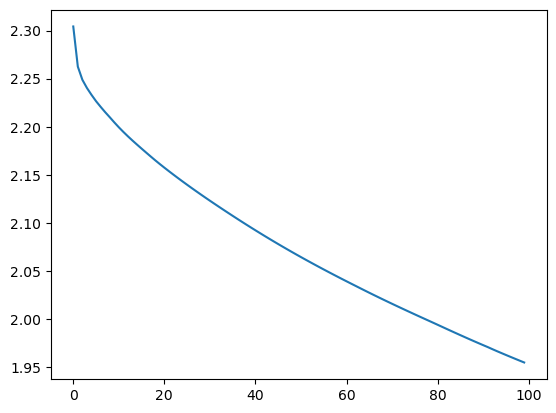

In [228]:
plt.plot(losses)
plt.show()

In [229]:
with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))

In [230]:
print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

model의 output은 :  [0.02651779 0.7035912  0.03098915 0.05626294 0.03709421 0.03487038
 0.0447927  0.04228492 0.0136702  0.00992649]
argmax를 한 후의 output은 1
accuracy는 0.8925925925925926


시도9-2\
활성화함수 : Sigmoid \
optimizer : Adagrad 사용 lr= 0.1 \
accuracy : 0.9777 -> 감소

In [231]:
from sklearn.datasets import load_digits
data=load_digits()

In [232]:
input = data.data 
output = data.target 

In [233]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device == "cuda":
  torch.cuda.manual_seed_all(777)

In [234]:
x_train, x_test, y_train, y_test = train_test_split(input, output, test_size = 0.3, random_state = 42, stratify= data.target, shuffle = True)

x_train = torch.FloatTensor(x_train).to(device)
y_train = torch.LongTensor(y_train).to(device)
x_test = torch.FloatTensor(x_test)
y_test = torch.LongTensor(y_test)

In [235]:
from torch.utils.data import Dataset
class CustomDataset(Dataset):
  def __init__(self): # 데이터셋의 입력 데이터/ 출력 데이터 초기화
    self.x_data = x_train
    self.y_data = [[y] for y in y_train]
#  데이터셋의 전처리를 해주는 부분

  def __len__(self):
    return len(self.x_data)
#  데이터셋의 길이. 즉, 총 샘플의 수를 적어주는 부분

  def __getitem__(self, idx): # 특정 인덱스에 해당하는
    x = torch.FloatTensor(self.x_data[idx]).to(device)
    y = torch.LongTensor(self.y_data[idx]).to(device)
#  데이터셋에서 특정 1개의 샘플을 가져오는 함수

    return x,y

In [236]:
batch_size = 8

dataset = CustomDataset() # 객체를 생성해서 커스텀데이터셋 만듬
dataloader = DataLoader(dataset, batch_size=batch_size) # 데이터셋, 배치 크기 전달

In [237]:
# input_layer와 hidden_layer의 노드 개수를 어떻게 바꿔줘야할까?
# hidden layer/neuron 수를 바꾸기

model = nn.Sequential(
          nn.Linear(64,1257, bias=True),
          nn.Sigmoid(),
          nn.Linear(1257,30, bias=True),
          nn.Sigmoid(),
          nn.Linear(30,15, bias=True),
          nn.Sigmoid(),
          nn.Linear(15,10, bias=True),

          nn.Softmax()
          ).to(device)

In [238]:
class Model(torch.nn.Module):

  def __init__(self):
    super(Model, self).__init__()
    self.layer1 = nn.Sequential(
          nn.Linear(64,1257, bias=True), # input_layer = 30, hidden_layer1 = 398
          nn.Sigmoid(),
        nn.BatchNorm1d(1257)
    )
  # activation function 이용
  #   nn.ReLU()
  #   nn.tanH()
  #   https://pytorch.org/docs/stable/nn.html 그 외에도 여기서 확인 가능함
  #   파라미터가 필요하지 않다는 것이 특징

  # batch normazliation 1d, 파라미터 값으로 vector의 길이를 전해줌
  # 추후에 이미지를 다루게 된다면, 그때는 batch normalization 2d를 이용하게 됨
  # 그때는 파라미터 값으로 채널, 가로, 세로 길이를 전달해주게 됨

    self.layer2 = nn.Sequential(
          nn.Linear(1257,30, bias=True), # hidden_layer1 = 398, hidden_layer2 = 30
        nn.Sigmoid()
    )
    self.layer3 = nn.Sequential(
          nn.Linear(30,15, bias=True), # hidden_layer1 = 30, hidden_layer2 = 15

        nn.Sigmoid()
    )

    self.layer4 = nn.Sequential(
          nn.Linear(15, 10, bias=True), # hidden_layer3 = 15, output_layer = 10

        nn.Softmax()
    )

  def forward(self,x):
    output = self.layer1(x)
    output = self.layer2(output)
    output = self.layer3(output)
    output = self.layer4(output)
    return output

In [239]:
def init_weights(layer):
    if isinstance(layer, nn.Linear):
        torch.nn.init.xavier_uniform(layer.weight)
        layer.bias.data.fill_(0.01)

        #xavier사용
        # Layer의 weight를 어떤 분포를 가지도록 초기화시켜줌+global minimum찾기 위해서

In [240]:
model = Model().to(device)
model.apply(init_weights)

C:\Users\withy\AppData\Local\Temp\ipykernel_8516\2101624760.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(layer.weight)


Model(
  (layer1): Sequential(
    (0): Linear(in_features=64, out_features=1257, bias=True)
    (1): Sigmoid()
    (2): BatchNorm1d(1257, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=1257, out_features=30, bias=True)
    (1): Sigmoid()
  )
  (layer3): Sequential(
    (0): Linear(in_features=30, out_features=15, bias=True)
    (1): Sigmoid()
  )
  (layer4): Sequential(
    (0): Linear(in_features=15, out_features=10, bias=True)
    (1): Softmax(dim=None)
  )
)

In [241]:
print(model)

Model(
  (layer1): Sequential(
    (0): Linear(in_features=64, out_features=1257, bias=True)
    (1): Sigmoid()
    (2): BatchNorm1d(1257, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=1257, out_features=30, bias=True)
    (1): Sigmoid()
  )
  (layer3): Sequential(
    (0): Linear(in_features=30, out_features=15, bias=True)
    (1): Sigmoid()
  )
  (layer4): Sequential(
    (0): Linear(in_features=15, out_features=10, bias=True)
    (1): Softmax(dim=None)
  )
)


In [242]:
loss_fn  = nn.CrossEntropyLoss().to(device)

# 여러가지 optimizer 시도해보기
# lr 바꿔보기

optimizer = optim.Adagrad(model.parameters(), lr= 0.1)

# https://pytorch.org/docs/stable/optim.html#module-torch.optim 페이지 참조
# optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
# sgd 등등

In [243]:
losses = []
for epoch in range(100):

  optimizer.zero_grad()
  hypothesis = model(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())

C:\Users\withy\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


0 2.3041915893554688
10 1.9468687772750854
20 1.7307251691818237
30 1.6032243967056274
40 1.582695484161377
50 1.5735349655151367
60 1.5568381547927856
70 1.5046509504318237
80 1.4832044839859009
90 1.4770547151565552


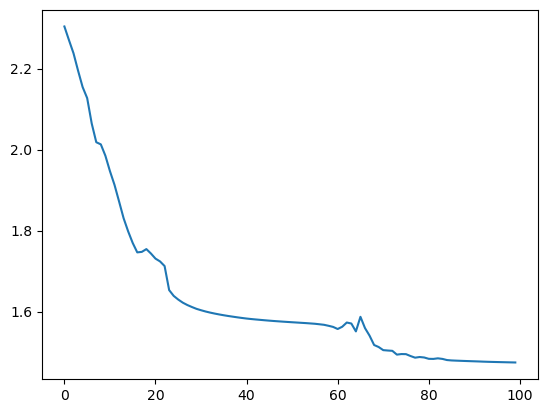

In [244]:
plt.plot(losses)
plt.show()

In [245]:
with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))

In [246]:
print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

model의 output은 :  [1.2094492e-05 9.8333687e-01 3.8921928e-03 2.1177130e-04 1.5923980e-03
 5.8742025e-05 2.5611967e-04 8.2719862e-04 9.6238758e-03 1.8871577e-04]
argmax를 한 후의 output은 1
accuracy는 0.9777777777777777


시도9-3\
활성화함수 : Sigmoid \
optimizer : Adagrad 사용 lr= 0.05 \
accuracy : 0.9796 ->살짝 감소

In [247]:
from sklearn.datasets import load_digits
data=load_digits()

In [248]:
input = data.data 
output = data.target 

In [249]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device == "cuda":
  torch.cuda.manual_seed_all(777)

In [250]:
x_train, x_test, y_train, y_test = train_test_split(input, output, test_size = 0.3, random_state = 42, stratify= data.target, shuffle = True)

x_train = torch.FloatTensor(x_train).to(device)
y_train = torch.LongTensor(y_train).to(device)
x_test = torch.FloatTensor(x_test)
y_test = torch.LongTensor(y_test)

In [251]:
from torch.utils.data import Dataset
class CustomDataset(Dataset):
  def __init__(self): # 데이터셋의 입력 데이터/ 출력 데이터 초기화
    self.x_data = x_train
    self.y_data = [[y] for y in y_train]
#  데이터셋의 전처리를 해주는 부분

  def __len__(self):
    return len(self.x_data)
#  데이터셋의 길이. 즉, 총 샘플의 수를 적어주는 부분

  def __getitem__(self, idx): # 특정 인덱스에 해당하는
    x = torch.FloatTensor(self.x_data[idx]).to(device)
    y = torch.LongTensor(self.y_data[idx]).to(device)
#  데이터셋에서 특정 1개의 샘플을 가져오는 함수

    return x,y

In [252]:
batch_size = 8

dataset = CustomDataset() # 객체를 생성해서 커스텀데이터셋 만듬
dataloader = DataLoader(dataset, batch_size=batch_size) # 데이터셋, 배치 크기 전달

In [253]:
# input_layer와 hidden_layer의 노드 개수를 어떻게 바꿔줘야할까?
# hidden layer/neuron 수를 바꾸기

model = nn.Sequential(
          nn.Linear(64,1257, bias=True),
          nn.Sigmoid(),
          nn.Linear(1257,30, bias=True),
          nn.Sigmoid(),
          nn.Linear(30,15, bias=True),
          nn.Sigmoid(),
          nn.Linear(15,10, bias=True),

          nn.Softmax()
          ).to(device)

In [254]:
class Model(torch.nn.Module):

  def __init__(self):
    super(Model, self).__init__()
    self.layer1 = nn.Sequential(
          nn.Linear(64,1257, bias=True), # input_layer = 30, hidden_layer1 = 398
          nn.Sigmoid(),
        nn.BatchNorm1d(1257)
    )
  # activation function 이용
  #   nn.ReLU()
  #   nn.tanH()
  #   https://pytorch.org/docs/stable/nn.html 그 외에도 여기서 확인 가능함
  #   파라미터가 필요하지 않다는 것이 특징

  # batch normazliation 1d, 파라미터 값으로 vector의 길이를 전해줌
  # 추후에 이미지를 다루게 된다면, 그때는 batch normalization 2d를 이용하게 됨
  # 그때는 파라미터 값으로 채널, 가로, 세로 길이를 전달해주게 됨

    self.layer2 = nn.Sequential(
          nn.Linear(1257,30, bias=True), # hidden_layer1 = 398, hidden_layer2 = 30
        nn.Sigmoid()
    )
    self.layer3 = nn.Sequential(
          nn.Linear(30,15, bias=True), # hidden_layer1 = 30, hidden_layer2 = 15

        nn.Sigmoid()
    )

    self.layer4 = nn.Sequential(
          nn.Linear(15, 10, bias=True), # hidden_layer3 = 15, output_layer = 10

        nn.Softmax()
    )

  def forward(self,x):
    output = self.layer1(x)
    output = self.layer2(output)
    output = self.layer3(output)
    output = self.layer4(output)
    return output

In [255]:
def init_weights(layer):
    if isinstance(layer, nn.Linear):
        torch.nn.init.xavier_uniform(layer.weight)
        layer.bias.data.fill_(0.01)

        #xavier사용
        # Layer의 weight를 어떤 분포를 가지도록 초기화시켜줌+global minimum찾기 위해서

In [256]:
model = Model().to(device)
model.apply(init_weights)

C:\Users\withy\AppData\Local\Temp\ipykernel_8516\2101624760.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(layer.weight)


Model(
  (layer1): Sequential(
    (0): Linear(in_features=64, out_features=1257, bias=True)
    (1): Sigmoid()
    (2): BatchNorm1d(1257, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=1257, out_features=30, bias=True)
    (1): Sigmoid()
  )
  (layer3): Sequential(
    (0): Linear(in_features=30, out_features=15, bias=True)
    (1): Sigmoid()
  )
  (layer4): Sequential(
    (0): Linear(in_features=15, out_features=10, bias=True)
    (1): Softmax(dim=None)
  )
)

In [257]:
print(model)

Model(
  (layer1): Sequential(
    (0): Linear(in_features=64, out_features=1257, bias=True)
    (1): Sigmoid()
    (2): BatchNorm1d(1257, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=1257, out_features=30, bias=True)
    (1): Sigmoid()
  )
  (layer3): Sequential(
    (0): Linear(in_features=30, out_features=15, bias=True)
    (1): Sigmoid()
  )
  (layer4): Sequential(
    (0): Linear(in_features=15, out_features=10, bias=True)
    (1): Softmax(dim=None)
  )
)


In [258]:
loss_fn  = nn.CrossEntropyLoss().to(device)

# 여러가지 optimizer 시도해보기
# lr 바꿔보기

optimizer = optim.Adagrad(model.parameters(), lr= 0.05)

# https://pytorch.org/docs/stable/optim.html#module-torch.optim 페이지 참조
# optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
# sgd 등등

In [259]:
losses = []
for epoch in range(100):

  optimizer.zero_grad()
  hypothesis = model(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())

C:\Users\withy\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


0 2.3041915893554688
10 1.9925057888031006
20 1.7599518299102783
30 1.664503574371338
40 1.616753339767456
50 1.6838716268539429
60 1.523766279220581
70 1.5083805322647095
80 1.4994213581085205
90 1.493310809135437


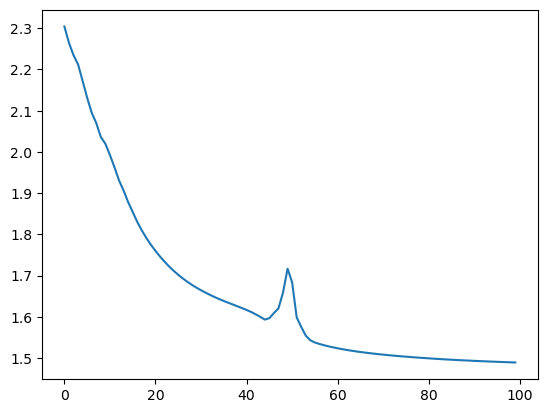

In [260]:
plt.plot(losses)
plt.show()

In [261]:
with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))

In [262]:
print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

model의 output은 :  [2.6433063e-03 9.7372615e-01 1.1463869e-02 1.4015806e-03 1.4922851e-03
 1.5284357e-03 9.6408126e-04 1.8179093e-03 4.9431026e-03 1.9095773e-05]
argmax를 한 후의 output은 1
accuracy는 0.9796296296296296


# < 3주차 과제 2 : CNN 맛보기>

In [263]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

In [264]:
# Training settings

batch_size = 64

# MNIST Dataset
train_dataset = datasets.MNIST(root='./data/',
                               train=True,
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root='./data/',
                              train=False,
                              transform=transforms.ToTensor())

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

In [265]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(1, 10, kernel_size = 5) #2차원 컨볼루션 층. 출력 특성 맵 크기는 (28-5+1)**2
    self.conv2 = nn.Conv2d(10, 20, kernel_size = 5) # 2차원 컨볼루션 층 (24-5+1)**2
    self.mp = nn.MaxPool2d(2) # 2차원 맥스풀링 층
    self.fc = nn.Linear(320 , 10) ### : 알맞는 input은?

  def forward(self, x):
    in_size = x.size(0)
    x = F.relu(self.mp(self.conv1(x))) # 활성화 하수 적용하고 mp층 통과
    x = F.relu(self.mp(self.conv2(x)))
    x = x.view(in_size, -1)
    x = self.fc(x)
    return F.log_softmax(x) # 소프트맥스 함수 적용해서 확률값을 얻음

In [266]:
model = Net()
optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum = 0.5) # 모델의 매개변수 업데이트

In [267]:
def train(epoch):
  model.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    data, target = Variable(data), Variable(target)
    optimizer.zero_grad()
    output = model(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % 10 == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
          epoch, batch_idx * len(data), len(train_loader.dataset),
          100. * batch_idx / len(train_loader), loss.item()))

In [268]:
def test():
    model.eval() #model.eval() 의 기능은?
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += F.nll_loss(output, target, size_average=False).data # nll_loss?? / cross entropy loss와의 관계 확인!
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [269]:
for epoch in range(1, 10):
    train(epoch)
    test()

C:\Users\withy\AppData\Local\Temp\ipykernel_8516\3132182234.py:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x) # 소프트맥스 함수 적용해서 확률값을 얻음


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.297009
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.281682
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.268403
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.253052
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.227583
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.179734
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.153206
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.110325
Train Epoch: 1 [5120/60000 (9%)]	Loss: 1.948063
Train Epoch: 1 [5760/60000 (10%)]	Loss: 1.698967
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.592418
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.262719
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.972404
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.802533
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.695400
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.603826
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.710427
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.596674
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.458078
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.662337
Train Epoch: 1 [12800/60000 (

C:\Users\withy\AppData\Local\Temp\ipykernel_8516\2324877592.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data, target = Variable(data, volatile=True), Variable(target)
C:\Users\withy\anaconda3\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.1581, Accuracy: 9503/10000 (95%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.076499
Train Epoch: 2 [640/60000 (1%)]	Loss: 0.121997
Train Epoch: 2 [1280/60000 (2%)]	Loss: 0.095462
Train Epoch: 2 [1920/60000 (3%)]	Loss: 0.091645
Train Epoch: 2 [2560/60000 (4%)]	Loss: 0.070817
Train Epoch: 2 [3200/60000 (5%)]	Loss: 0.137833
Train Epoch: 2 [3840/60000 (6%)]	Loss: 0.046461
Train Epoch: 2 [4480/60000 (7%)]	Loss: 0.089011
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.224440
Train Epoch: 2 [5760/60000 (10%)]	Loss: 0.276411
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.149684
Train Epoch: 2 [7040/60000 (12%)]	Loss: 0.125353
Train Epoch: 2 [7680/60000 (13%)]	Loss: 0.107352
Train Epoch: 2 [8320/60000 (14%)]	Loss: 0.344231
Train Epoch: 2 [8960/60000 (15%)]	Loss: 0.439609
Train Epoch: 2 [9600/60000 (16%)]	Loss: 0.094103
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.116923
Train Epoch: 2 [10880/60000 (18%)]	Loss: 0.235869
Train Epoch: 2 [11520/60000 (19%)]	Loss: 0.104549
Train Epoch: 2 [12

Train Epoch: 3 [44160/60000 (74%)]	Loss: 0.203776
Train Epoch: 3 [44800/60000 (75%)]	Loss: 0.173554
Train Epoch: 3 [45440/60000 (76%)]	Loss: 0.073424
Train Epoch: 3 [46080/60000 (77%)]	Loss: 0.123111
Train Epoch: 3 [46720/60000 (78%)]	Loss: 0.080457
Train Epoch: 3 [47360/60000 (79%)]	Loss: 0.035333
Train Epoch: 3 [48000/60000 (80%)]	Loss: 0.119469
Train Epoch: 3 [48640/60000 (81%)]	Loss: 0.076513
Train Epoch: 3 [49280/60000 (82%)]	Loss: 0.048410
Train Epoch: 3 [49920/60000 (83%)]	Loss: 0.024074
Train Epoch: 3 [50560/60000 (84%)]	Loss: 0.047784
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.047324
Train Epoch: 3 [51840/60000 (86%)]	Loss: 0.106076
Train Epoch: 3 [52480/60000 (87%)]	Loss: 0.166229
Train Epoch: 3 [53120/60000 (88%)]	Loss: 0.196948
Train Epoch: 3 [53760/60000 (90%)]	Loss: 0.049127
Train Epoch: 3 [54400/60000 (91%)]	Loss: 0.103385
Train Epoch: 3 [55040/60000 (92%)]	Loss: 0.026342
Train Epoch: 3 [55680/60000 (93%)]	Loss: 0.041310
Train Epoch: 3 [56320/60000 (94%)]	Loss: 0.048340


Train Epoch: 5 [28160/60000 (47%)]	Loss: 0.023262
Train Epoch: 5 [28800/60000 (48%)]	Loss: 0.045321
Train Epoch: 5 [29440/60000 (49%)]	Loss: 0.046926
Train Epoch: 5 [30080/60000 (50%)]	Loss: 0.051600
Train Epoch: 5 [30720/60000 (51%)]	Loss: 0.066865
Train Epoch: 5 [31360/60000 (52%)]	Loss: 0.058672
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.038819
Train Epoch: 5 [32640/60000 (54%)]	Loss: 0.056621
Train Epoch: 5 [33280/60000 (55%)]	Loss: 0.104369
Train Epoch: 5 [33920/60000 (57%)]	Loss: 0.024048
Train Epoch: 5 [34560/60000 (58%)]	Loss: 0.179787
Train Epoch: 5 [35200/60000 (59%)]	Loss: 0.039310
Train Epoch: 5 [35840/60000 (60%)]	Loss: 0.077656
Train Epoch: 5 [36480/60000 (61%)]	Loss: 0.080536
Train Epoch: 5 [37120/60000 (62%)]	Loss: 0.039642
Train Epoch: 5 [37760/60000 (63%)]	Loss: 0.042261
Train Epoch: 5 [38400/60000 (64%)]	Loss: 0.061775
Train Epoch: 5 [39040/60000 (65%)]	Loss: 0.097385
Train Epoch: 5 [39680/60000 (66%)]	Loss: 0.033216
Train Epoch: 5 [40320/60000 (67%)]	Loss: 0.055629


Train Epoch: 7 [12160/60000 (20%)]	Loss: 0.177002
Train Epoch: 7 [12800/60000 (21%)]	Loss: 0.079678
Train Epoch: 7 [13440/60000 (22%)]	Loss: 0.027344
Train Epoch: 7 [14080/60000 (23%)]	Loss: 0.098478
Train Epoch: 7 [14720/60000 (25%)]	Loss: 0.010956
Train Epoch: 7 [15360/60000 (26%)]	Loss: 0.095805
Train Epoch: 7 [16000/60000 (27%)]	Loss: 0.029868
Train Epoch: 7 [16640/60000 (28%)]	Loss: 0.219432
Train Epoch: 7 [17280/60000 (29%)]	Loss: 0.014423
Train Epoch: 7 [17920/60000 (30%)]	Loss: 0.125118
Train Epoch: 7 [18560/60000 (31%)]	Loss: 0.079142
Train Epoch: 7 [19200/60000 (32%)]	Loss: 0.041658
Train Epoch: 7 [19840/60000 (33%)]	Loss: 0.120010
Train Epoch: 7 [20480/60000 (34%)]	Loss: 0.035212
Train Epoch: 7 [21120/60000 (35%)]	Loss: 0.021535
Train Epoch: 7 [21760/60000 (36%)]	Loss: 0.016453
Train Epoch: 7 [22400/60000 (37%)]	Loss: 0.042662
Train Epoch: 7 [23040/60000 (38%)]	Loss: 0.287872
Train Epoch: 7 [23680/60000 (39%)]	Loss: 0.008184
Train Epoch: 7 [24320/60000 (41%)]	Loss: 0.096842


Train Epoch: 8 [56960/60000 (95%)]	Loss: 0.031192
Train Epoch: 8 [57600/60000 (96%)]	Loss: 0.017280
Train Epoch: 8 [58240/60000 (97%)]	Loss: 0.020181
Train Epoch: 8 [58880/60000 (98%)]	Loss: 0.062796
Train Epoch: 8 [59520/60000 (99%)]	Loss: 0.238597

Test set: Average loss: 0.0507, Accuracy: 9839/10000 (98%)

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.071010
Train Epoch: 9 [640/60000 (1%)]	Loss: 0.052055
Train Epoch: 9 [1280/60000 (2%)]	Loss: 0.028068
Train Epoch: 9 [1920/60000 (3%)]	Loss: 0.072026
Train Epoch: 9 [2560/60000 (4%)]	Loss: 0.039973
Train Epoch: 9 [3200/60000 (5%)]	Loss: 0.076412
Train Epoch: 9 [3840/60000 (6%)]	Loss: 0.060067
Train Epoch: 9 [4480/60000 (7%)]	Loss: 0.046130
Train Epoch: 9 [5120/60000 (9%)]	Loss: 0.054195
Train Epoch: 9 [5760/60000 (10%)]	Loss: 0.050365
Train Epoch: 9 [6400/60000 (11%)]	Loss: 0.079095
Train Epoch: 9 [7040/60000 (12%)]	Loss: 0.053913
Train Epoch: 9 [7680/60000 (13%)]	Loss: 0.113250
Train Epoch: 9 [8320/60000 (14%)]	Loss: 0.187094
Train Epoch: 9 [